# Text classification general overview
In this part, we aim to perform text classification in general. The training dataset contains 35000 Abstracts with 7 labels, including Medical, Computer science, psychology, civilization engineering, biochemistry, astronomy and physics. We try several word embedding methods, including Word2vec, Glove and FastText and TF-IDF, also, we adopt three methods for text classification, including TextCNN, a simple three layer neural network and random forest classifier.

In [1]:
NB_WORDS = 10000  # number of words in the dictionary
NB_START_EPOCHS = 10  # number of epochs used for training
BATCH_SIZE = 512  # batch size for training

Read data and labels from train.txt, if train.txt containing in the current folder, it can be starter of the program.

In [2]:
import numpy as np
import pandas as pd
import csv
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
import gc
import collections
import itertools
from nltk import bigrams
import networkx as nx
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers
# define the array to save label and text
labels = []
texts = []
NB_WORDS = 10000  # number of words to be inserted in dictionary
NB_START_EPOCHS = 10  # Number of epochs used for training
BATCH_SIZE = 512 # batch size for training

# read the file line by line
with open('train.txt', 'r') as train_dataset:
    for row in train_dataset:
        row = row.strip()  # delete \n and space from
        # split label and text accoding to space
        splits = row.split(' ', 1)
        labels.append(splits[0].replace('__label__', ''))
        texts.append(splits[1])
# extract the Abstracts for each category
x_CS = [text for text, label in zip(texts, labels) if label == 'CS']
x_Civil = [text for text, label in zip(texts, labels) if label == 'Civil']
x_biochemistry = [text for text, label in zip(texts, labels) if label == 'biochemistry']
x_Medical = [text for text, label in zip(texts, labels) if label == 'Medical']
x_Psychology = [text for text, label in zip(texts, labels) if label == 'Psychology']
x_astronomy = [text for text, label in zip(texts, labels) if label == 'astronomy']
x_physics = [text for text, label in zip(texts, labels) if label == 'physics']
# encode labels to numerical format
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(labels)
label_mapping = {label: encoded_label for label, encoded_label in zip(labels, y_encoded)}

concatenate cs, biochemistry, psychology, medical and civil subcategories to form the training dataset and labels, encode the label into numerical format, clean the abstract using special symbol removal, lower the sentences, stopword removal, tokenization and lemmatization, construct a vocabulary of NB_WORDS and tokenize text using the Keras Tokenizer

In [3]:
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
x = x_CS + x_Civil + x_biochemistry + x_Medical + x_Psychology + x_astronomy + x_physics
# clean the sentences: lower the sentences, tokenization, remove the stopwords, lemmatization
x_clean = [re.sub(r'[^a-zA-Z\s]', u'',sentence.replace('\n', ''), flags=re.UNICODE) for sentence in x]
#keep the first 200 words in the passage
a200 = [list(filter(lambda w: w not in stop_words and len(w)>2, map(lemmatizer.lemmatize, sentence.lower().split()))) for sentence in x_clean]
max_passage_length200 = max(len(x) for x in a200)
#map the cleaned sentences with passage id
passage = dict(zip(range(0,len(a200)),a200))
del x_clean
# Get the number of samples in the arrays
num_samples = len(a200)

# Create a random permutation of indices
random_indices = np.random.permutation(num_samples)

# Use the random indices to shuffle the arrays
shuffled_passages = np.array(a200)[random_indices]
shuffled_labels = np.array(y_encoded)[random_indices]
# initialize tokenizer, only considering the most occured NB_WORDS words
tk = Tokenizer(num_words=NB_WORDS)

# train tokenizer to fit the passage
tk.fit_on_texts(shuffled_passages)
# transform text into sequences
X_seq = tk.texts_to_sequences(shuffled_passages)
max_passage_length200 = max(len(x) for x in a200)
# encode the label into one hot category
y_category = to_categorical(shuffled_labels)

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/mac/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-3-24ec7af7ab96>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  shuffled_passages = np.array(a200)[random_indices]


select the first 500 Abstract for each category for tuning the parameter, for instance, parameters in Word2vec, Random Forest, padding length, embedding length, etc, tokenizing the passages and convert the label into one hot word format

In [4]:
# get the first 500 passages in each category
x_samples = x_CS[:500] + x_Civil[:500] + x_biochemistry[:500] + x_Medical[:500] + x_Psychology[:500] + x_astronomy[:500] + x_physics[:500]
labels_sample = ['CS'] * 500 + ['Civil'] * 500 + ['biochemistry'] * 500 + ['Medical'] * 500 + ['Psychology'] * 500 + ['astronomy'] * 500 +['physics'] * 500
# clean the passages
x_samples_clean = [re.sub(r'[^a-zA-Z\s]', u'',sentence.replace('\n', ''), flags=re.UNICODE) for sentence in x_samples]
x_samples_clean = [list(filter(lambda w: w not in stop_words and len(w)>2, map(lemmatizer.lemmatize, sentence.lower().split()))) for sentence in x_samples_clean]
passage_samples = dict(zip(range(0,len(x_samples_clean)), x_samples_clean))
#encode labels into numerical format
y_encoded_samples = encoder.fit_transform(labels_sample)
# Create a random permutation of indices
random_indices = np.random.permutation(len(x_samples_clean))
# Use the random indices to shuffle the arrays
shuffled_passages_samples = np.array(x_samples_clean)[random_indices]
shuffled_labels_samples = np.array(y_encoded_samples)[random_indices]
# initialize tokenizer
tk_samples = Tokenizer(num_words=NB_WORDS)
# train tokenizer to fit the passage
tk_samples.fit_on_texts(shuffled_passages_samples)
x_samples_seq_sub = tk_samples.texts_to_sequences(shuffled_passages_samples)
# transform the numerical encoding to one hot format
y_samples_category_sub = to_categorical(shuffled_labels_samples)

<ipython-input-4-edfbc69c60a7>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  shuffled_passages_samples = np.array(x_samples_clean)[random_indices]


In [5]:
x_samples_seq = tk.texts_to_sequences(x_samples_clean)
y_samples_category = to_categorical(y_encoded_samples)

print the label name with its corresponding encoding number

In [6]:
print(label_mapping)

{'CS': 0, 'biochemistry': 5, 'Psychology': 3, 'Medical': 2, 'Civil': 1, 'astronomy': 4, 'physics': 6}


In [7]:
vocabulary_array = []
word_counts_array = []

plot ten most used nouns in CS category

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mac/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/mac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


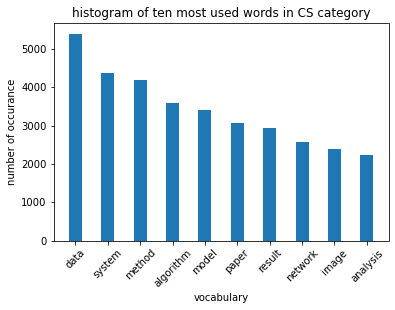

In [8]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import matplotlib.pyplot as plt
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
x_CS_clean = [re.sub(r'[^a-zA-Z\s]', u'',sentence.replace('\n', ''), flags=re.UNICODE) for sentence in x_CS]
CS_200 = [list(filter(lambda w: w not in stop_words and len(w)>2, map(lemmatizer.lemmatize, sentence.lower().split())))[:200] for sentence in x_CS_clean]
result_string = ' '.join(' '.join(sublist) for sublist in CS_200)
tokens = word_tokenize(result_string)
#delete verb and keep noun
filters = [w for w, pos in pos_tag(tokens) if pos != 'VB' and pos != 'VBD' and pos != 'VBG' and pos != 'VBN' and pos != 'VBP' and pos != 'VBZ']
#count the number of occurance of the words
word_dictionary = {}
for w in filters:
  if w not in word_dictionary:
    word_dictionary[w] = 1
  else:
    word_dictionary[w] += 1
# sort the words with its occurance
sorted_word_counts = sorted(word_dictionary.items(), key=lambda x: x[1], reverse=True)
del word_dictionary, tokens, filters
vocabularies = [t[0] for t in sorted_word_counts]
word_counts = [t[1] for t in sorted_word_counts]
vocabulary_array.append(vocabularies)
word_counts_array.append(word_counts)
# print out top 10 occurred with its number of occurance into a bar chart
plt.bar(vocabularies[:10], word_counts[:10], width=0.4)
plt.title('histogram of ten most used words in CS category')
plt.xlabel('vocabulary')
plt.ylabel('number of occurance')
plt.xticks(rotation=45)
plt.show()

plot a network to show the frequency of bigram in CS category

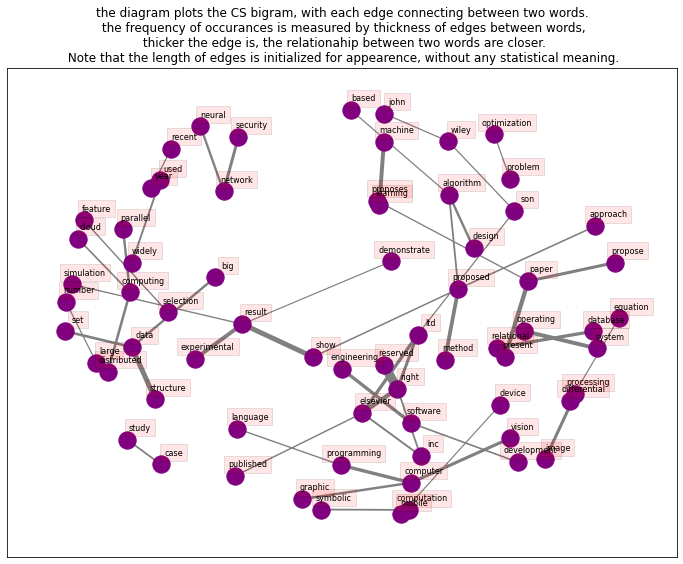

In [9]:
CS_bigrams = [list(nltk.bigrams(sequence)) for sequence in CS_200]
CS_bigrams = list(itertools.chain(*CS_bigrams))
del x_CS_clean
del CS_200
CS_counts = collections.Counter(CS_bigrams)
G = nx.Graph()
for key, value in CS_counts.most_common(50):
    G.add_edge(key[0], key[1], weight=value)
# the thinkness of the line between a pair of words corresponds to word occurance/100
edge = [G[i][j]['weight']/100 for i, j in G.edges()]

figure, axis = plt.subplots(figsize=(12, 9))
# k corresponds to the distance between two words
p = nx.spring_layout(G,k = 3)

# plot networks, use weight as edge thinkness, the choice of the value of k depends on how compact you want the graph to be. Increased k values ​​may lead to larger distances between nodes, while smaller k values ​​may make the graph more compact
nx.draw_networkx(G, p,
                 font_size=16,
                 width=edge,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=axis)

for key, value in p.items():
    x, y = value[0]+.045, value[1]+.045
    axis.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.1),
            horizontalalignment='center', fontsize=8)
plt.title('the diagram plots the CS bigram, with each edge connecting between two words.\n the frequency of occurances is measured by thickness of edges between words,\n thicker the edge is, the relationahip between two words are closer.\n Note that the length of edges is initialized for appearence, without any statistical meaning.')
plt.show()

the diagram plots the CS bigram, with edges connecting the words, the frequency of occurances is measured by thickness of edges between words, thicker the edge is, the relationahip between two words are closer. Note that the length of edges is initialized for appearence, without any statistical meaning.

plot ten most used nouns in astronomy category

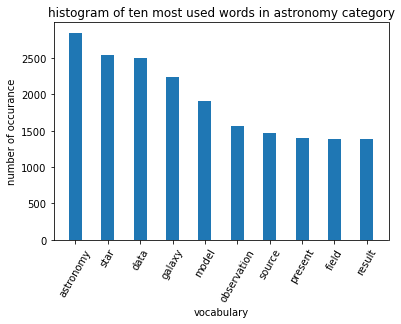

In [10]:
x_astronomy_clean = [re.sub(r'[^a-zA-Z\s]', u'',sentence.replace('\n', ''), flags=re.UNICODE) for sentence in x_astronomy]
astronomy_200 = [list(filter(lambda w: w not in stop_words and len(w)>2, map(lemmatizer.lemmatize, sentence.lower().split())))[:200] for sentence in x_astronomy_clean]
result_string = ' '.join(' '.join(sublist) for sublist in astronomy_200)
#del x_MAE_clean, MAE_200
tokens = word_tokenize(result_string)
#delete verb and keep noun
filters = [w for w, pos in pos_tag(tokens) if pos != 'VB' and pos != 'VBD' and pos != 'VBG' and pos != 'VBN' and pos != 'VBP' and pos != 'VBZ']
#count the number of occurance of the words
word_dictionary = {}
for w in filters:
  if w not in word_dictionary:
    word_dictionary[w] = 1
  else:
    word_dictionary[w] += 1
# sort the words with its occurance
sorted_word_counts = sorted(word_dictionary.items(), key=lambda x: x[1], reverse=True)
del word_dictionary, tokens, filters
vocabularies = [t[0] for t in sorted_word_counts]
word_counts = [t[1] for t in sorted_word_counts]
vocabulary_array.append(vocabularies)
word_counts_array.append(word_counts)
# print out each word with its number of occurance into a bar chart
plt.bar(vocabularies[:10], word_counts[:10], width=0.4)
plt.title('histogram of ten most used words in astronomy category')
plt.xlabel('vocabulary')
plt.ylabel('number of occurance')
plt.xticks(rotation=60)
plt.show()

from the diagram, we can see that the top 10 keyword of class astronomy is astronomy, star, data, galaxy, model, observation, source, present, field, result, from keywords like astronomy, star, galaxy, it can be clearly analyzed that this kind of abstract is related to astronomy.

plot a network to show the frequency of bigram in astronomy category

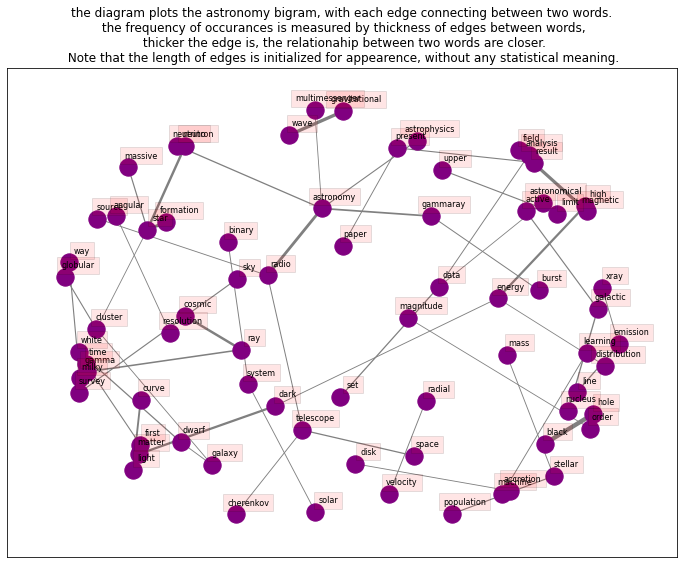

In [11]:
astronomy_bigrams = [list(nltk.bigrams(sequence)) for sequence in astronomy_200]

astronomy_bigrams = list(itertools.chain(*astronomy_bigrams))
del x_astronomy_clean
del astronomy_200

astronomy_counts = collections.Counter(astronomy_bigrams)
G = nx.Graph()
for key, value in astronomy_counts.most_common(50):
    #if k[0] != 'degree':
    G.add_edge(key[0], key[1], weight=value)

edge = [G[i][j]['weight']/100 for i, j in G.edges()]

figure, axis = plt.subplots(figsize=(12, 9))

p = nx.spring_layout(G, k=3)

# Plot networks, use weight as edge thinkness
nx.draw_networkx(G, p,
                 font_size=16,
                 width=edge,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=axis)

for key, value in p.items():
    x, y = value[0]+.045, value[1]+.045
    axis.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.1),
            horizontalalignment='center', fontsize=8)
plt.title('the diagram plots the astronomy bigram, with each edge connecting between two words.\n the frequency of occurances is measured by thickness of edges between words,\n thicker the edge is, the relationahip between two words are closer.\n Note that the length of edges is initialized for appearence, without any statistical meaning.')
plt.show()

the diagram plots astronomy bigram, with edges connecting the words, the frequency of occurances is measured by thickness of edges between words, thicker the edge is, the relationahip between two words are closer. Note that the length of edges is initialized for appearence, without any statistical meaning.

plot ten most used nouns in biochemistry category

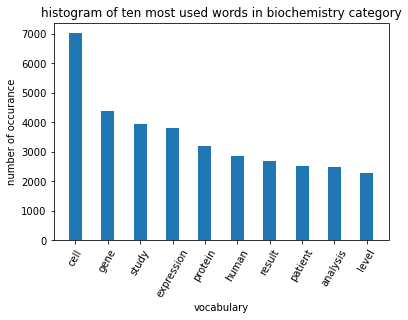

In [12]:
x_biochemistry_clean = [re.sub(r'[^a-zA-Z\s]', u'',sentence.replace('\n', ''), flags=re.UNICODE) for sentence in x_biochemistry]
biochemistry_200 = [list(filter(lambda w: w not in stop_words and len(w)>2, map(lemmatizer.lemmatize, sentence.lower().split())))[:200] for sentence in x_biochemistry_clean]
result_string = ' '.join(' '.join(sublist) for sublist in biochemistry_200)
#del x_biochemistry_clean, biochemistry_200
tokens = word_tokenize(result_string)
#delete verb and keep noun
filters = [w for w, pos in pos_tag(tokens) if pos != 'VB' and pos != 'VBD' and pos != 'VBG' and pos != 'VBN' and pos != 'VBP' and pos != 'VBZ']
#count the number of occurance of the words
word_dictionary = {}
for w in filters:
  if w not in word_dictionary:
    word_dictionary[w] = 1
  else:
    word_dictionary[w] += 1
# sort the words with its occurance
sorted_word_counts = sorted(word_dictionary.items(), key=lambda x: x[1], reverse=True)
del word_dictionary, tokens, filters
# print out each word with its number of occurance into a bar chart
vocabularies = [t[0] for t in sorted_word_counts]
word_counts = [t[1] for t in sorted_word_counts]
vocabulary_array.append(vocabularies)
word_counts_array.append(word_counts)
plt.bar(vocabularies[:10], word_counts[:10], width=0.4)
plt.title('histogram of ten most used words in biochemistry category')
plt.xlabel('vocabulary')
plt.ylabel('number of occurance')
plt.xticks(rotation=60)
plt.show()

from the diagram, we can see that the top 10 keyword of class biochemistry is cell, gene, study, expression, protein, human, result, analysis, patient, level, from keywords like cell, gene, protein, it can be clearly analyzed that this kind of abstract is related to biology. Note that the keyword is quite similar with medical since both of them are associated with organisms and health-related aspects.

plot a network to show the frequency of bigram in biochemistry category

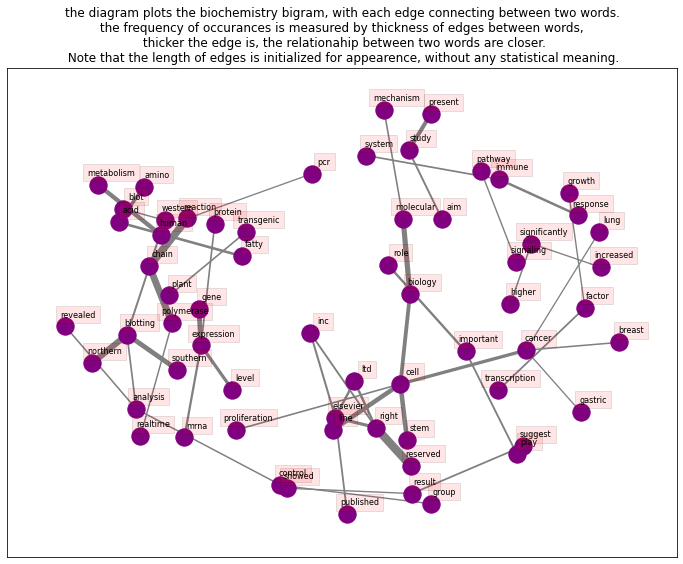

In [13]:
biochemistry_bigrams = [list(nltk.bigrams(sequence)) for sequence in biochemistry_200]
for array in x_biochemistry_clean:
  del array
del x_biochemistry_clean
for array in biochemistry_200:
  del array
del biochemistry_200
biochemistry_bigrams = list(itertools.chain(*biochemistry_bigrams))

biochemistry_counts = collections.Counter(biochemistry_bigrams)
G = nx.Graph()
for key, value in biochemistry_counts.most_common(50):
    G.add_edge(key[0], key[1], weight=value)
edge = [G[i][j]['weight']/100 for i, j in G.edges()]

figure, axis = plt.subplots(figsize=(12, 9))

p = nx.spring_layout(G, k=3)

# Plot networks, use weight as edge thinkness
nx.draw_networkx(G, p,
                 font_size=16,
                 width=edge,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=axis)

for key, value in p.items():
    x, y = value[0]+.045, value[1]+.045
    axis.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.1),
            horizontalalignment='center', fontsize=8)
plt.title('the diagram plots the biochemistry bigram, with each edge connecting between two words.\n the frequency of occurances is measured by thickness of edges between words, \n thicker the edge is, the relationahip between two words are closer.\n Note that the length of edges is initialized for appearence, without any statistical meaning.')
plt.show()

the diagram plots biochemistry bigram, with edges connecting the words, the frequency of occurances is measured by thickness of edges between words, thicker the edge is, the relationahip between two words are closer. Note that the length of edges is initialized for appearence, without any statistical meaning.

plot ten most used nouns from Psychology category

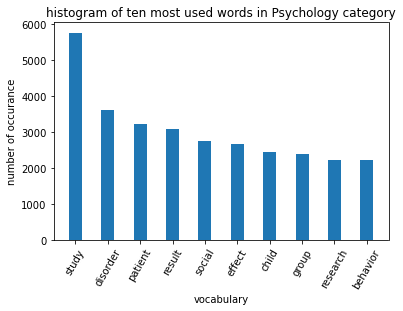

In [14]:
x_Psychology_clean = [re.sub(r'[^a-zA-Z\s]', u'',sentence.replace('\n', ''), flags=re.UNICODE) for sentence in x_Psychology]
Psychology_200 = [list(filter(lambda w: w not in stop_words and len(w)>2, map(lemmatizer.lemmatize, sentence.lower().split())))[:200] for sentence in x_Psychology_clean]
result_string = ' '.join(' '.join(sublist) for sublist in Psychology_200)
#del x_Psychology_clean, Psychology_200
tokens = word_tokenize(result_string)
#delete verb and keep noun
filters = [w for w, pos in pos_tag(tokens) if pos != 'VB' and pos != 'VBD' and pos != 'VBG' and pos != 'VBN' and pos != 'VBP' and pos != 'VBZ']
#count the number of occurance of the words
word_dictionary = {}
for w in filters:
  if w not in word_dictionary:
    word_dictionary[w] = 1
  else:
    word_dictionary[w] += 1
# sort the words with its occurance
sorted_word_counts = sorted(word_dictionary.items(), key=lambda x: x[1], reverse=True)
del word_dictionary, tokens, filters
vocabularies = [t[0] for t in sorted_word_counts]
word_counts = [t[1] for t in sorted_word_counts]
vocabulary_array.append(vocabularies)
word_counts_array.append(word_counts)
# print out each word with its number of occurance into a bar chart
plt.bar(vocabularies[:10], word_counts[:10], width=0.4)
plt.title('histogram of ten most used words in Psychology category')
plt.xlabel('vocabulary')
plt.ylabel('number of occurance')
plt.xticks(rotation=60)
plt.show()

from the diagram, we can see that the top 10 keyword of class psychology is study, disorder, result, effect, social, patient, child, group, behavior, research, from keywords like behavior, it can be clearly analyzed that this kind of abstract is related to psychology. Note that the keyword is quite similar with medical since both of them are associated with human relationship and health-related aspects.

plot a network to show the frequency of bigram in Psychology category

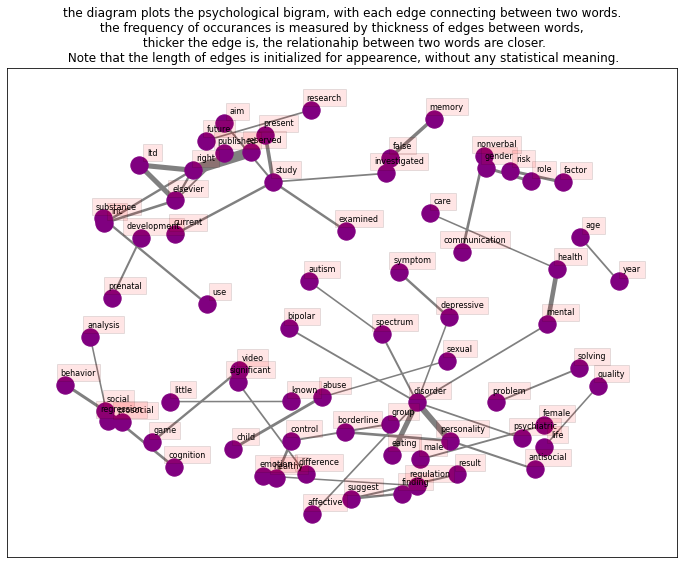

In [15]:
#x_Psychology_clean = [re.sub(r'[^a-zA-Z\s]', u'',sentence.replace('\n', ''), flags=re.UNICODE) for sentence in x_Psychology]
#Psychology_200 = [list(filter(lambda w: w not in stop_words and len(w)>2, map(lemmatizer.lemmatize, sentence.lower().split())))[:200] for sentence in x_Psychology_clean]

Psychology_bigrams = [list(nltk.bigrams(sequence)) for sequence in Psychology_200]
for array in x_Psychology_clean:
  del array
del x_Psychology_clean
for array in Psychology_200:
  del array
del Psychology_200

Psychology_bigrams = list(itertools.chain(*Psychology_bigrams))

Psychology_counts = collections.Counter(Psychology_bigrams)
G = nx.Graph()
for key, value in Psychology_counts.most_common(50):
    G.add_edge(key[0], key[1], weight=value)
edge = [G[i][j]['weight']/100 for i, j in G.edges()]
figure, axis = plt.subplots(figsize=(12, 9))

p = nx.spring_layout(G, k=3)

# Plot networks
nx.draw_networkx(G, p,
                 font_size=16,
                 width=edge,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=axis)

# Create offset labels
for key, value in p.items():
    x, y = value[0]+.045, value[1]+.045
    axis.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.1),
            horizontalalignment='center', fontsize=8)
plt.title('the diagram plots the psychological bigram, with each edge connecting between two words.\n the frequency of occurances is measured by thickness of edges between words, \n thicker the edge is, the relationahip between two words are closer.\n Note that the length of edges is initialized for appearence, without any statistical meaning.')
plt.show()

the diagram plots psychology bigram, with edges connecting the words, the frequency of occurances is measured by thickness of edges between words, thicker the edge is, the relationahip between two words are closer. Note that the length of edges is initialized for appearence, without any statistical meaning.

plot ten most used nouns of Medical category

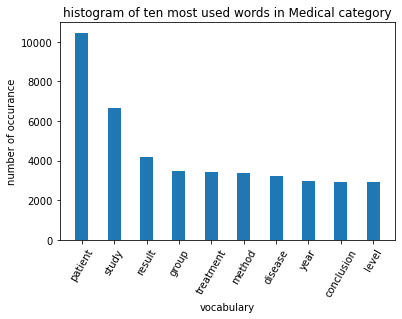

In [16]:
x_Medical_clean = [re.sub(r'[^a-zA-Z\s]', u'',sentence.replace('\n', ''), flags=re.UNICODE) for sentence in x_Medical]
Medical_200 = [list(filter(lambda w: w not in stop_words and len(w)>2, map(lemmatizer.lemmatize, sentence.lower().split())))[:200] for sentence in x_Medical_clean]
result_string = ' '.join(' '.join(sublist) for sublist in Medical_200)
#del x_Medical_clean, Medical_200
tokens = word_tokenize(result_string)
#delete verb and keep noun
filters = [w for w, pos in pos_tag(tokens) if pos != 'VB' and pos != 'VBD' and pos != 'VBG' and pos != 'VBN' and pos != 'VBP' and pos != 'VBZ']
#count the number of occurance of the words
word_dictionary = {}
for w in filters:
  if w not in word_dictionary:
    word_dictionary[w] = 1
  else:
    word_dictionary[w] += 1
# sort the words with its occurance
sorted_word_counts = sorted(word_dictionary.items(), key=lambda x: x[1], reverse=True)
del word_dictionary, tokens, filters
# print out each word with its number of occurance into a bar chart
vocabularies = [t[0] for t in sorted_word_counts]
word_counts = [t[1] for t in sorted_word_counts]
vocabulary_array.append(vocabularies)
word_counts_array.append(word_counts)
plt.bar(vocabularies[:10], word_counts[:10], width=0.4)
plt.title('histogram of ten most used words in Medical category')
plt.xlabel('vocabulary')
plt.ylabel('number of occurance')
plt.xticks(rotation=60)
plt.show()

from the diagram, we can see that the top 10 keyword of class medical is patient, study, result, treatment, group, disease, level, health, effect, year, from keywords like patient, health, treatment, disease, it can be clearly analyzed that this kind of abstract is related to medical.

plot a network to show the frequency of bigram in Medical category

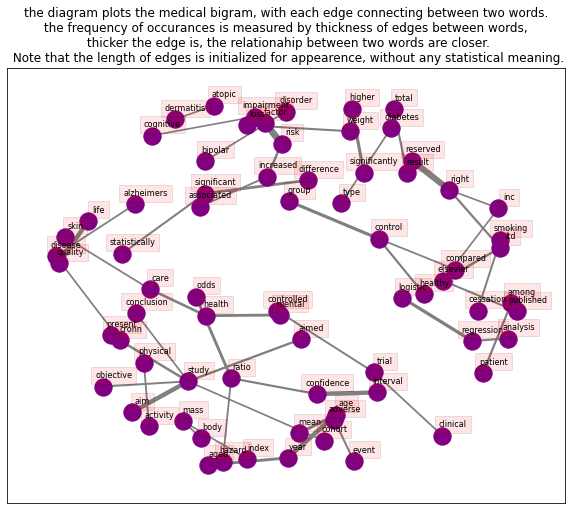

In [17]:
Medical_bigrams = [list(nltk.bigrams(sequence)) for sequence in Medical_200]
for array in x_Medical_clean:
  del array
del x_Medical_clean
for array in Medical_200:
  del array
del Medical_200

Medical_bigrams = list(itertools.chain(*Medical_bigrams))

Medical_counts = collections.Counter(Medical_bigrams)
G = nx.Graph()
for key, value in Medical_counts.most_common(50):
    G.add_edge(key[0], key[1], weight=value)
edge = [G[i][j]['weight']/100 for i, j in G.edges()]

figure, axis = plt.subplots(figsize=(10, 8))

p = nx.spring_layout(G, k=3)

# Plot networks
nx.draw_networkx(G, p,
                 font_size=16,
                 width=edge,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=axis)

# Create offset labels
for key, value in p.items():
    x, y = value[0]+.045, value[1]+.045
    axis.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.1),
            horizontalalignment='center', fontsize=8)
plt.title('the diagram plots the medical bigram, with each edge connecting between two words.\n the frequency of occurances is measured by thickness of edges between words, \n thicker the edge is, the relationahip between two words are closer.\n Note that the length of edges is initialized for appearence, without any statistical meaning.')
plt.show()

the diagram plots medical bigram, with edges connecting the words, the frequency of occurances is measured by thickness of edges between words, thicker the edge is, the relationship between two words are closer. Note that the length of edges is initialized for appearence, without any statistical meaning.

plot ten most used nouns of physics category

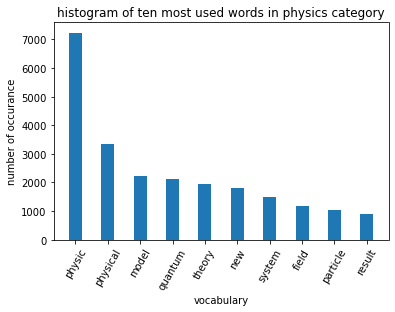

In [18]:
x_physics_clean = [re.sub(r'[^a-zA-Z\s]', u'',sentence.replace('\n', ''), flags=re.UNICODE) for sentence in x_physics]
physics_200 = [list(filter(lambda w: w not in stop_words and len(w)>2, map(lemmatizer.lemmatize, sentence.lower().split())))[:200] for sentence in x_physics_clean]
result_string = ' '.join(' '.join(sublist) for sublist in physics_200)
#del x_ECE_clean, ECE_200
tokens = word_tokenize(result_string)
#delete verb and keep noun
filters = [w for w, pos in pos_tag(tokens) if pos != 'VB' and pos != 'VBD' and pos != 'VBG' and pos != 'VBN' and pos != 'VBP' and pos != 'VBZ']
#count the number of occurance of the words
word_dictionary = {}
for w in filters:
  if w not in word_dictionary:
    word_dictionary[w] = 1
  else:
    word_dictionary[w] += 1
# sort the words with its occurance
sorted_word_counts = sorted(word_dictionary.items(), key=lambda x: x[1], reverse=True)
del word_dictionary, tokens, filters
vocabularies = [t[0] for t in sorted_word_counts]
word_counts = [t[1] for t in sorted_word_counts]
vocabulary_array.append(vocabularies)
word_counts_array.append(word_counts)
# print out each word with its number of occurance into a bar chart
plt.bar(vocabularies[:10], word_counts[:10], width=0.4)
plt.title('histogram of ten most used words in physics category')
plt.xlabel('vocabulary')
plt.ylabel('number of occurance')
plt.xticks(rotation=60)
plt.show()

from the diagram, we can see that the top 10 keyword of class physics is physic, physical, model, quantum, theory, new, system, field, particle, result, from keywords like physic, physical, quantum, particle, it can be clearly analyzed that this kind of abstract is related to physics.

plot a network to show the frequency of bigram in physics category

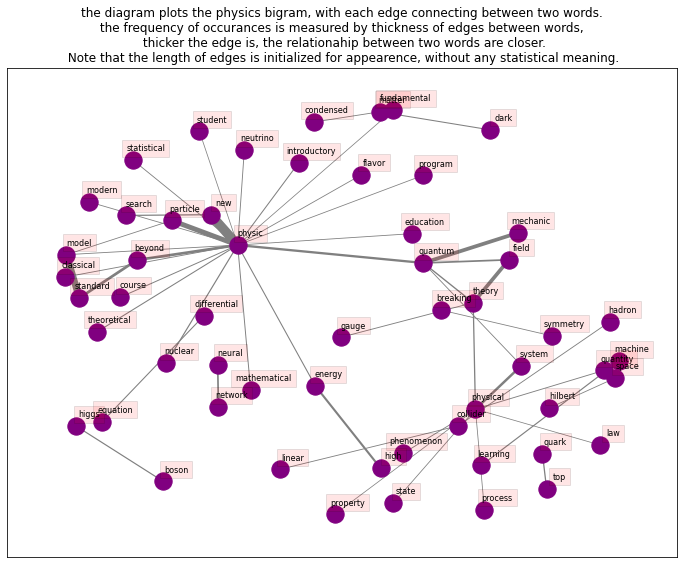

In [19]:
#x_ECE_clean = [re.sub(r'[^a-zA-Z\s]', u'',sentence.replace('\n', ''), flags=re.UNICODE) for sentence in x_ECE]
#ECE_200 = [list(filter(lambda w: w not in stop_words and len(w)>2, map(lemmatizer.lemmatize, sentence.lower().split())))[:200] for sentence in x_ECE_clean]
physics_bigrams = [list(nltk.bigrams(sequence)) for sequence in physics_200]
for array in x_physics_clean:
  del array
del x_physics_clean
for array in physics_200:
  del array
del physics_200

physics_bigrams = list(itertools.chain(*physics_bigrams))

physics_counts = collections.Counter(physics_bigrams)
G = nx.Graph()
for key, value in physics_counts.most_common(50):
    G.add_edge(key[0], key[1], weight=value)
edge = [G[i][j]['weight']/100 for i, j in G.edges()]
figure, axis = plt.subplots(figsize=(12, 9))

p = nx.spring_layout(G, k=3)

# Plot networks
nx.draw_networkx(G, p,
                 font_size=16,
                 width=edge,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=axis)

for key, value in p.items():
    x, y = value[0]+.045, value[1]+.045
    axis.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.1),
            horizontalalignment='center', fontsize=8)
plt.title('the diagram plots the physics bigram, with each edge connecting between two words.\n the frequency of occurances is measured by thickness of edges between words, \n thicker the edge is, the relationahip between two words are closer.\n Note that the length of edges is initialized for appearence, without any statistical meaning.')
plt.show()

the diagram plots physics bigram, with edges connecting the words, the frequency of occurances is measured by thickness of edges between words, thicker the edge is, the relationship between two words are closer. Note that the length of edges is initialized for appearence, without any statistical meaning.

plot ten most used words in Civilization engineering category

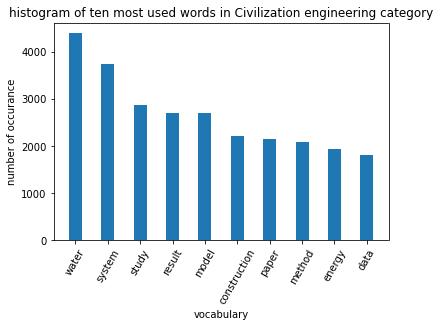

In [20]:
x_Civil_clean = [re.sub(r'[^a-zA-Z\s]', u'',sentence.replace('\n', ''), flags=re.UNICODE) for sentence in x_Civil]
Civil_200 = [list(filter(lambda w: w not in stop_words and len(w)>2, map(lemmatizer.lemmatize, sentence.lower().split())))[:200] for sentence in x_Civil_clean]
result_string = ' '.join(' '.join(sublist) for sublist in Civil_200)
#del x_Civil_clean, Civil_200
tokens = word_tokenize(result_string)
#delete verb and keep noun
filters = [w for w, pos in pos_tag(tokens) if pos != 'VB' and pos != 'VBD' and pos != 'VBG' and pos != 'VBN' and pos != 'VBP' and pos != 'VBZ']
#count the number of occurance of the words
word_dictionary = {}
for w in filters:
  if w not in word_dictionary:
    word_dictionary[w] = 1
  else:
    word_dictionary[w] += 1
# sort the words with its occurance
sorted_word_counts = sorted(word_dictionary.items(), key=lambda x: x[1], reverse=True)
del word_dictionary, tokens, filters
vocabularies = [t[0] for t in sorted_word_counts]
word_counts = [t[1] for t in sorted_word_counts]
vocabulary_array.append(vocabularies)
word_counts_array.append(word_counts)
plt.bar(vocabularies[:10], word_counts[:10], width=0.4)
plt.title('histogram of ten most used words in Civilization engineering category')
plt.xlabel('vocabulary')
plt.ylabel('number of occurance')
plt.xticks(rotation=60)
plt.show()

from the diagram, we can see that the top 10 keyword of class Civilization engineering is water, system, study, result, model construction, paper, method, energy, data, from keywords like water, construction, energy, it can be clearly analyzed that this kind of abstract is related to civilization engineering. Note that the keywords of Civilization engineering is quite like MAE, since thay are both subcatgories of manufacturing.

plot a network to show the frequency of bigram in Civil category

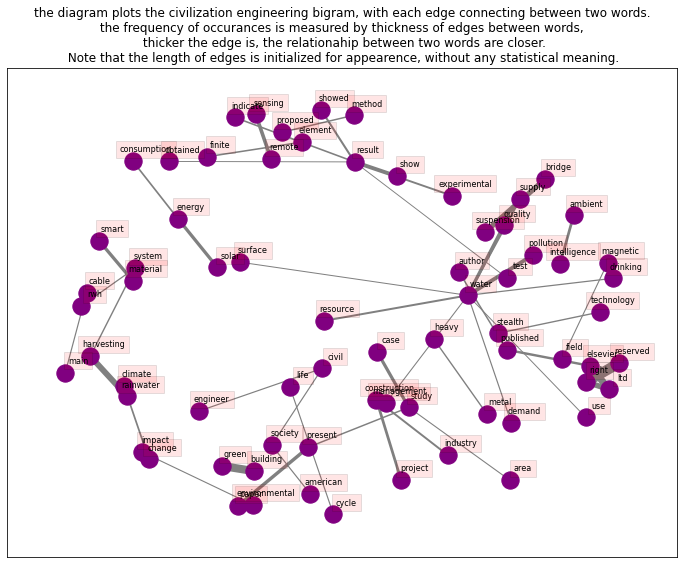

In [21]:
Civil_bigrams = [list(nltk.bigrams(sequence)) for sequence in Civil_200]
for array in x_Civil_clean:
  del array
del x_Civil_clean
for array in Civil_200:
  del array
del Civil_200

Civil_bigrams = list(itertools.chain(*Civil_bigrams))

Civil_counts = collections.Counter(Civil_bigrams)
import networkx as nx
G = nx.Graph()
for key, value in Civil_counts.most_common(50):
    G.add_edge(key[0], key[1], weight=value)
edge = [G[i][j]['weight']/100 for i, j in G.edges()]
figure, axis = plt.subplots(figsize=(12, 9))

p = nx.spring_layout(G, k=3)

# Plot networks
nx.draw_networkx(G, p,
                 font_size=16,
                 width=edge,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=axis)

for key, value in p.items():
    x, y = value[0]+.045, value[1]+.045
    axis.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.1),
            horizontalalignment='center', fontsize=8)
plt.title('the diagram plots the civilization engineering bigram, with each edge connecting between two words.\n the frequency of occurances is measured by thickness of edges between words, \n thicker the edge is, the relationahip between two words are closer.\n Note that the length of edges is initialized for appearence, without any statistical meaning.')
plt.show()

the diagram plots civilization engineering bigram, with edges connecting the words, the frequency of occurances is measured by thickness of edges between words, thicker the edge is, the relationship between two words are closer. Note that the length of edges is initialized for appearence, without any statistical meaning.

use random search to find the best parameter of word2vec, with random forest to evaluate the accuarcy of prediction, the parameter set achieves the best accuracy will be selected as the best parameters

In [22]:
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(list(passage_samples.values()), y_encoded_samples, test_size=0.20, random_state=42)
def train_word2vec_and_get_vectors(X_train, X_test, params):
    '''
    params:
      X_train: cleaned training passages
      X_test: cleaned testing passages
      params: parameters of word2vec, including sg_cbow, vector_length, window_size, count_min, negative, hs
    returns:
      the average word embedding of training dataset
      the average word embedding of testing dataset
    '''
    # train the word2vec model using different set of parameters
    model = Word2Vec(list(passage_samples.values()), sg=params['sg_cbow'], vector_size=params['vector_length'],
                     window=params['window_size'], min_count=params['count_min'], negative=params['negative'],
                     hs=params['hs'], workers=4)
    # encode the abstracts into average word embedding
    def get_vectors(X):
        vectors = []
        for x in X:
            if len(x) != 0:
                filtered_words = [word for word in x if word in model.wv.key_to_index]
                vectors.append(np.sum(model.wv[filtered_words], axis=0) / len(filtered_words))
            else:
                vectors.append(np.zeros(params['vector_length']))
        return vectors

    return get_vectors(X_train), get_vectors(X_test)

# parameters distribution
param_dist = {
    'vector_length': [50, 100, 200, 300],
    'negative': [3, 5, 7],
    'sg_cbow': [0, 1],
    'window_size': [5, 7, 9],
    'count_min': [1, 2, 3],
    'hs': [0, 1]
}

# number of random search
n_iter_search = 50
best_accuracy = 0
params_dict = []

for _ in range(n_iter_search):
    # randomly choose the value of each parameter
    params = {key: random.choice(value) for key, value in param_dist.items()}
    # return the embeddings of training and testing abstracts
    X_train_vec, X_test_vec = train_word2vec_and_get_vectors(X_train, X_test, params)
    # use the random forest classifier to train the model
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=-1)
    rf_model.fit(X_train_vec, y_train)
    # get the prediction labels
    y_pred = rf_model.predict(X_test_vec)
    # calculate the accuracy of predictions
    acc = accuracy_score(y_test, y_pred)
    # get the parameter and best accuracy
    if acc > best_accuracy:
        best_accuracy = acc
        best_params = params

    print(f"Iteration {_}: Accuracy = {acc}, Params = {params}")
    params.update({"accuracy": acc})
    params_dict.append(params)
# print out the best accuracy and best set of parameters
print(f"Best Accuracy = {best_accuracy}, Best Params = {best_params}")



Iteration 0: Accuracy = 0.74, Params = {'vector_length': 300, 'negative': 3, 'sg_cbow': 0, 'window_size': 5, 'count_min': 1, 'hs': 1}
Iteration 1: Accuracy = 0.7828571428571428, Params = {'vector_length': 300, 'negative': 5, 'sg_cbow': 1, 'window_size': 9, 'count_min': 1, 'hs': 1}
Iteration 2: Accuracy = 0.7442857142857143, Params = {'vector_length': 50, 'negative': 3, 'sg_cbow': 0, 'window_size': 7, 'count_min': 2, 'hs': 1}
Iteration 3: Accuracy = 0.7214285714285714, Params = {'vector_length': 200, 'negative': 5, 'sg_cbow': 0, 'window_size': 5, 'count_min': 2, 'hs': 1}
Iteration 4: Accuracy = 0.7457142857142857, Params = {'vector_length': 50, 'negative': 5, 'sg_cbow': 1, 'window_size': 9, 'count_min': 1, 'hs': 0}
Iteration 5: Accuracy = 0.7685714285714286, Params = {'vector_length': 300, 'negative': 7, 'sg_cbow': 1, 'window_size': 9, 'count_min': 2, 'hs': 0}
Iteration 6: Accuracy = 0.53, Params = {'vector_length': 200, 'negative': 5, 'sg_cbow': 0, 'window_size': 9, 'count_min': 1, 'hs

analyze the correlation of each parameter with accuracy

In [27]:
from scipy.stats import spearmanr
# extract the parameters of random search and accuracy
accuracy_list = [d['accuracy'] for d in params_dict]
vector_length_list = [d['vector_length'] for d in params_dict]
negative_list = [d['negative'] for d in params_dict]
sg_cbow_list = [d['sg_cbow'] for d in params_dict]
window_size_list = [d['window_size'] for d in params_dict]
count_min_list = [d['count_min'] for d in params_dict]
hs_list = [d['hs'] for d in params_dict]
# analyze the spearman correlation of values of each parameter and accuracy
correlation_vector_length, p_value_vector_length = spearmanr(vector_length_list, accuracy_list)
print("correlation of vector length with accuracy is ",correlation_vector_length)
correlation_negative, p_value_negative = spearmanr(negative_list, accuracy_list)
print("correlation between number of negative samples and accuracy is ", correlation_negative)
correlation_sg_cbow, p_value_sg_cbow = spearmanr(sg_cbow_list, accuracy_list)
print("correlation between sg cbow and accuracy is ", correlation_sg_cbow)
correlation_window_size, p_value_window_size = spearmanr(window_size_list, accuracy_list)
print("correlation between window size and accuracy is ",correlation_window_size)
correlation_count_min, p_value_count_min = spearmanr(count_min_list, accuracy_list)
print("correlation between minimum occurances and accuracy is ", correlation_count_min)
correlation_hs, p_value_hs = spearmanr(hs_list, accuracy_list)
print("correlation between hs and accuracy is ", correlation_hs)

correlation of vector length with accuracy is  0.10120410171396743
correlation between number of negative samples and accuracy is  0.21231044655717413
correlation between sg cbow and accuracy is  0.7924605883847833
correlation between window size and accuracy is  0.16721190793008311
correlation between minimum occurances and accuracy is  0.14975828814385567
correlation between hs and accuracy is  0.6117148522624922


the correlation between sg_cbow and accuracy, window_size with accuracy, background words number with accuracy, hs with accuracy has strong positive correlation, which suggests that skip-gram performs better than cbow, hierachical softmax performs better than negative sampling, accuracy increases with increasing window size . However, although low correlations show for vector length, background size and negative samples, the correlation do exists and strongly correlated elements affect the judgment of weakly correlated elements.

load the glove vectors from a file

In [30]:
def load_glove_vectors(path):
    '''
    params:
      path: the path of the Glove embedding file
    returns:
      a dictionary mapping each word to its embedding
    '''
    word_vectors = {}
    with open(path, 'r', encoding='utf-8') as file:
        for row in file:
            values = row.split()
            try:
              word_vectors[values[0]] = np.asarray(values[1:], dtype=np.float32)
            except:
              print(values[1:])
    return word_vectors

create word embedding vector from various input file to obtain different length of word embeddings, select the resource that obtains the best accuracy with random forest classifier

In [31]:
# input file of Glove
glove_path = ['glove.twitter.27B/glove.twitter.27B.25d.txt', 'glove.twitter.27B/glove.twitter.27B.50d.txt', 'glove.6B/glove.6B.50d.txt', 'glove.twitter.27B/glove.twitter.27B.100d.txt', 'glove.6B/glove.6B.100d.txt', 'glove.twitter.27B/glove.twitter.27B.200d.txt', 'glove.6B/glove.6B.200d.txt','glove.6B/glove.6B.300d.txt' ]
X_train, X_test, y_train, y_test = train_test_split(list(passage_samples.values()), y_encoded_samples, test_size=0.20, random_state=42)
acc_list = []
kappa_list = []
for path in glove_path:
    # create glove vector embedding from different input files
    word_vectors = load_glove_vectors(path)
    # calculate average word embedding of training dataset
    passages_vector_glove_train = []
    for x in X_train:
        filtered_words = [word for word in x if word in word_vectors]
        passages_vector_glove_train.append(np.sum([word_vectors[word] for word in filtered_words],axis=0)/len(filtered_words))
    # calculate average word embedding of testing dataset
    passages_vector_glove_test = []
    for x in X_test:
        filtered_words = [word for word in x if word in word_vectors]
        passages_vector_glove_test.append(np.sum([word_vectors[word] for word in filtered_words],axis=0)/len(filtered_words))
    # initialize the random forest classifier
    model = RandomForestClassifier(n_estimators=300, max_depth=150,n_jobs=-1)
    #fit training dataset x(word embedding vector) and y(category) into random forest classifier
    model.fit(np.array(passages_vector_glove_train), y_train)
    #predict testing category y according to testing TF-IDF vector X
    y_pred = model.predict(np.array(passages_vector_glove_test))
    #plot the confusion matrix and calculate prediction accuracy with cohen_kappa_score and accuracy_score of sklearn.metrics
    c_mat = confusion_matrix(y_test,y_pred)
    # calculate the accuracy and kappa score
    kappa = cohen_kappa_score(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    acc_list.append(acc)
    kappa_list.append(kappa)
    print ("Confusion Matrix:\n", c_mat)
    print ("\nKappa: ",kappa)
    print ("\nAccuracy: ",acc)
    for array in passages_vector_glove_train:
        del array
    for array in passages_vector_glove_test:
        del array
    for array in word_vectors:
        del array
    del passages_vector_glove_train, model,passages_vector_glove_test, word_vectors
for array in X_train:
    del array
for array in X_test:
    del array
del X_train, X_test, y_train, y_test

Confusion Matrix:
 [[79 19  1  2  9  9  7]
 [19 67  4  3  5  4  3]
 [ 2  5 41 21  1 28  3]
 [ 1  4 11 61  1  6  3]
 [ 5  4  2  3 62  1 12]
 [ 2  7 14  1  1 68  2]
 [ 5  3  1  3 19  3 63]]

Kappa:  0.5679393351556299

Accuracy:  0.63
Confusion Matrix:
 [[83 18  1  1  7  9  7]
 [15 76  1  2  4  5  2]
 [ 2  5 52 17  1 24  0]
 [ 0  6 10 65  1  3  2]
 [ 7  5  0  2 61  2 12]
 [ 0  5 13  3  2 70  2]
 [ 5  3  0  5 12  1 71]]

Kappa:  0.6295431031605647

Accuracy:  0.6828571428571428
Confusion Matrix:
 [[82 21  0  3  5  7  8]
 [19 74  1  2  4  4  1]
 [ 2  3 55 18  0 23  0]
 [ 1  5  8 67  2  4  0]
 [ 8  2  0  0 74  0  5]
 [ 4  1 12  1  1 76  0]
 [ 4  3  0  0  4  0 86]]

Kappa:  0.6894839519010165

Accuracy:  0.7342857142857143
Confusion Matrix:
 [[90 18  2  1  6  6  3]
 [17 78  2  2  1  3  2]
 [ 1  5 49 19  0 27  0]
 [ 0  4 12 64  2  4  1]
 [ 1  4  0  0 73  0 11]
 [ 1  3  9  2  1 77  2]
 [ 4  4  1  4  9  1 74]]

Kappa:  0.6745800533068864

Accuracy:  0.7214285714285714
Confusion Matrix:
 [[86 21

plot accuracy and kappa of different dataset, the x axis means different dataset, the y axis means the accuracy and kappa score

Given a source data glove.twitter.27B.25d.txt

glove.twitter.xx.xx      resource from twitter

glove.xx.xx              resource from Common Crawl

27B mean the vocabulary size

25d means the embedding dimension size

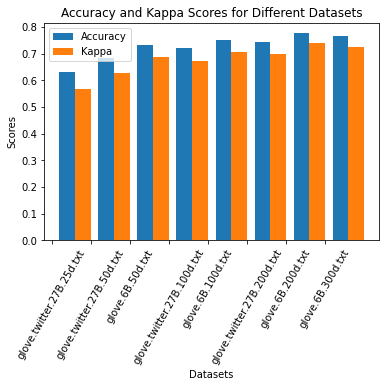

In [32]:
import matplotlib.pyplot as plt
source_data = ['glove.twitter.27B.25d.txt', 'glove.twitter.27B.50d.txt', 'glove.6B.50d.txt', 'glove.twitter.27B.100d.txt', 'glove.6B.100d.txt', 'glove.twitter.27B.200d.txt', 'glove.6B.200d.txt','glove.6B.300d.txt']
x = range(len(source_data))
plt.bar(x, acc_list, width=0.4, label='Accuracy')
plt.bar([row+0.4 for row in x], kappa_list, width=0.4, label='Kappa')
plt.title('Accuracy and Kappa Scores for Different Datasets')
plt.xticks([row-0.4 for row in x], source_data, rotation=60)
plt.xlabel('Datasets')
plt.ylabel('Scores')
plt.legend()
plt.show()

the accuracy and kappa of glove datasets increases with dimension, however, twitter gets relatively low accuracy so it is not considered a suitable dataset for abstract classification.

In [33]:
def deep_model(m, X, y, vX, vy):
    '''
    train a model for NB_START_EPOCHS, the optimization function is rmsprop, the loss function is categorical_crossentropy, the evaluation metrics is accuracy
    parameters:
      m - model
      X - training dataset
      y - training labels
      vX - validation dataset
      vy - validation labels
    '''
    m.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    history = m.fit(X, y, epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE, validation_data=(vX, vy), verbose=0)
    return history

def eval_metric(history_list, metric_name,params_list, default = 0):
    '''
    params:
      default: 0 tune the padding length, 1 tune the embedding length
      params_list:
        if default == 0 - a list of padding length
                      1 - a list of embedding length
      metric_name: validation or loss
      history_list: a list of training history for each epoch
    '''
    # Define a list of colors for each loop iteration
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'yellow','pink', 'black', 'gray' ,'olive', 'seagreen','brown']
    '''
    plot training and validation metrics together
    '''
    for i, history in enumerate(history_list):
        # extract the training accuracy
        metric = history.history[metric_name]
        # extract the validation accuracy
        val_metric = history.history['val_' + metric_name]
        e = range(1, NB_START_EPOCHS + 1)
        # Use the color from the list based on the loop index (i)
        if default == 0:
          plt.plot(e, metric, 'o-', label=f'training {metric_name} of Abstract with padding length {params_list[i]}', color=colors[i])
          plt.plot(e, val_metric, '-', label=f'validation {metric_name} of Abstract with padding length {params_list[i]}', color=colors[i])
        else:
          plt.plot(e, metric, 'o-', label=f'training {metric_name} of Abstract with embedding dimension {params_list[i]}', color=colors[i])
          plt.plot(e, val_metric, '-', label=f'validation {metric_name} of Abstract with embedding dimension {params_list[i]}', color=colors[i])
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.xlabel('epoch')
    plt.ylabel(f'{metric_name}')
    if default ==0:
      plt.title(f'train and validation {metric_name} obtained using different length of padding sequence')
    else:
      plt.title(f'train and validation {metric_name} obtained using different embedding dimension')
    plt.show()
    '''
    plot training metrics
    '''
    max = 0
    best_parameter = 0
    for i, history in enumerate(history_list):
        metric = history.history[metric_name]
        e = range(1, NB_START_EPOCHS + 1)
        # Use the color from the list based on the loop index (i)
        if default == 0:
          plt.plot(e, metric, 'o-', label=f'abstract length {params_list[i]}', color=colors[i])
        else:
          plt.plot(e, metric, 'o-', label=f'embedding length {params_list[i]}', color=colors[i])
        if metric_name == "accuracy":
          if history.history[metric_name][-1]> max:
            max = history.history[metric_name][-1]
            best_parameter = params_list[i]
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel(f'{metric_name}')
    if default ==0:
      plt.title(f'train {metric_name} obtained using different length of padding sequence')
    else:
      plt.title(f'train {metric_name} obtained using different embedding dimension')
    plt.show()
    '''
    plot validation metrics
    '''
    for i, history in enumerate(history_list):
        val_metric = history.history['val_' + metric_name]
        e = range(1, NB_START_EPOCHS + 1)
        # Use the color from the list based on the loop index (i)
        if default == 0:
          plt.plot(e, val_metric, '-', label=f'abstract length {params_list[i]}', color=colors[i])
        else:
          plt.plot(e, val_metric, '-', label=f'embedding length {params_list[i]}', color=colors[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel(f'{metric_name}')
    if default ==0:
      plt.title(f'validation {metric_name} obtained using different length of padding sequence')
    else:
      plt.title(f'validation {metric_name} obtained using different embedding dimension')
    plt.show()
    return best_parameter

split word index sequence and one hot category into training and testing dataset, create a word embedding model containing a word embedding layer, a flatten layer and a dense layer with softmax activition function

plot the training and validation accuracy and loss diagram for different padding length and select the best padding length for random word embedding, the parameter tuning steps work for the subsampling dataset

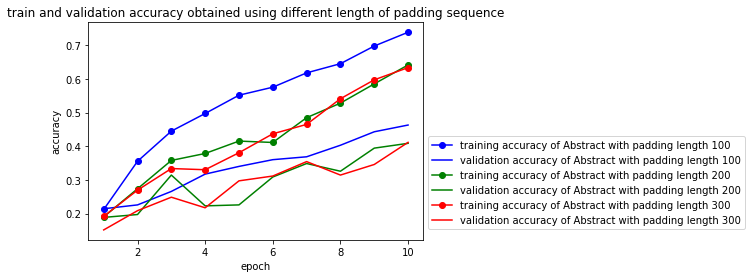

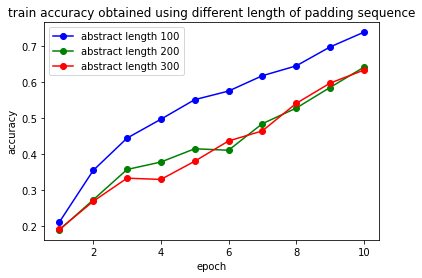

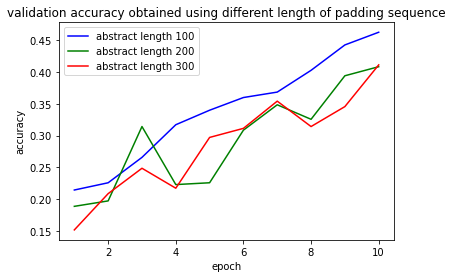

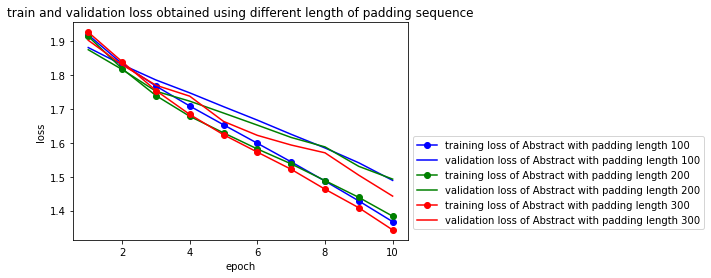

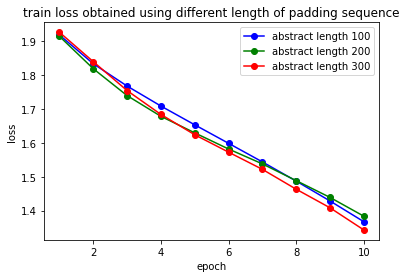

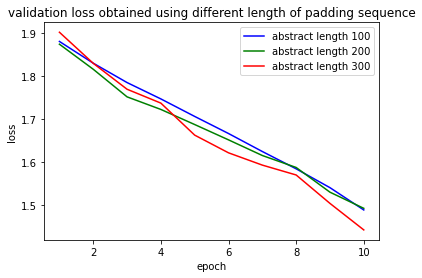

0

In [34]:
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import models
from keras import layers
history_list = []
MAX_LEN_list = [100,200,300]
# split into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(x_samples_seq, y_samples_category, test_size=0.1, random_state=37)
for MAX_LEN in MAX_LEN_list:
  # pad the senquences to max length
  X_train_trunc = pad_sequences(X_train, maxlen=MAX_LEN)
  X_test_trunc = pad_sequences(X_test, maxlen=MAX_LEN)
  #create a model to catelog the embedding words
  m = models.Sequential()
  m.add(layers.Embedding(NB_WORDS, 10, input_length=MAX_LEN))
  m.add(layers.Flatten())
  m.add(layers.Dense(7, activation='softmax'))
  history = deep_model(m, X_train_trunc, y_train, X_test_trunc, y_test)
  # print out accuracy and loss
  history_list.append(history)
  # Release the memory of the model
  del X_train_trunc, X_test_trunc,m
  K.clear_session()
best_abstract_length_random = eval_metric(history_list, 'accuracy',MAX_LEN_list, 0)
eval_metric(history_list, 'loss',MAX_LEN_list, 0)

plot the training and validation accuracy and loss diagram for different embedding dimension and select the best embedding dimension for random word embedding, the parameter tuning steps work for subsampling dataset

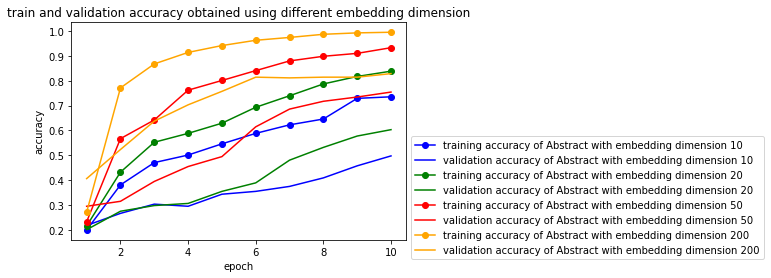

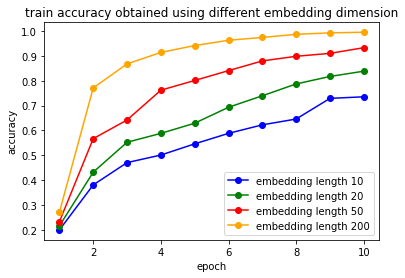

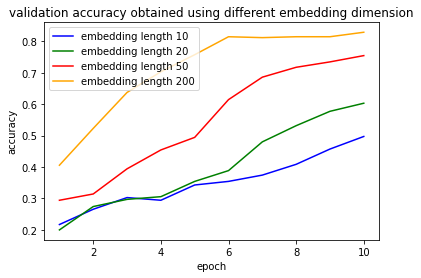

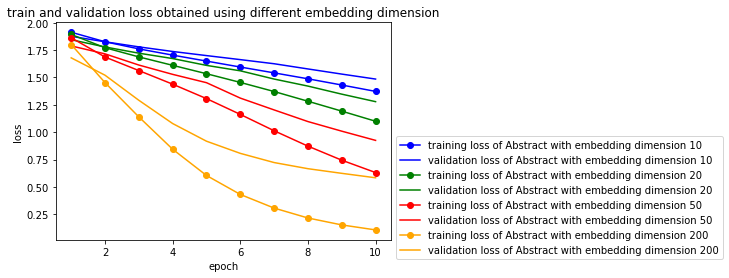

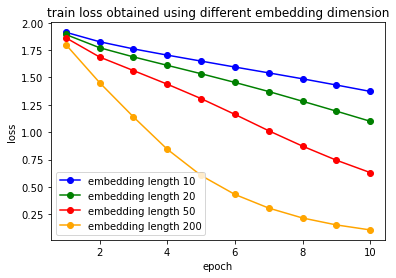

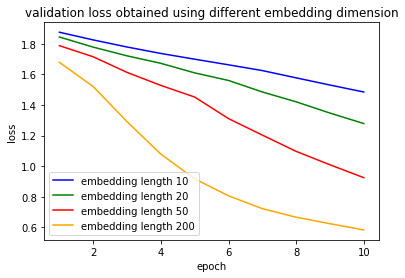

0

In [35]:
history_list = []
embedding_dimension_list = [10, 20, 50, 200]
# pad the senquences to max length
X_train_trunc = pad_sequences(X_train, maxlen=best_abstract_length_random)
X_test_trunc = pad_sequences(X_test, maxlen=best_abstract_length_random)
for embedding_dimension in embedding_dimension_list:
  #create a model to catelog the embedding words
  m = models.Sequential()
  m.add(layers.Embedding(NB_WORDS, embedding_dimension, input_length=best_abstract_length_random))
  m.add(layers.Flatten())
  m.add(layers.Dense(7, activation='softmax'))
  history = deep_model(m, X_train_trunc, y_train, X_test_trunc, y_test)
  # print out accuracy and loss
  history_list.append(history)
  # Release the memory of the model
  del m
  K.clear_session()
del X_train_trunc, X_test_trunc
best_embedding_length_random = eval_metric(history_list, 'accuracy', embedding_dimension_list, 1)
eval_metric(history_list, 'loss', embedding_dimension_list, 1)

use best abstract length and best embedding length to train the whole dataset

In [36]:
X_train_5000, X_test_5000, y_train_5000, y_test_5000 = train_test_split(X_seq, y_category, test_size=0.1, random_state=37)
# pad the senquences to max length
X_train_trunc_5000 = pad_sequences(X_train_5000, maxlen=best_abstract_length_random)
X_test_trunc_5000 = pad_sequences(X_test_5000, maxlen=best_abstract_length_random)
#create a model to catelog the embedding words
m = models.Sequential()
m.add(layers.Embedding(NB_WORDS, best_embedding_length_random, input_length=best_abstract_length_random))
m.add(layers.Flatten())
m.add(layers.Dense(7, activation='softmax'))
history = deep_model(m, X_train_trunc_5000, y_train_5000, X_test_trunc_5000, y_test_5000)
del X_train_trunc_5000
del X_test_trunc_5000

Word2vec representation of word embedding, each word in the vocabulary is represented as a dense vector, overfitting occurs and the performance is not good as random embedding

tune the embedding dimension for word2vec embedding method, firstly, construct a dictionary that maps each word to its word embedding vector, then feed the padding training and testing sequence to three layer neural network, find the embedding length with the best accuracy rate.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 10)           100000    
                                                                 
 flatten_1 (Flatten)         (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 7007      
                                                                 
Total params: 107,007
Trainable params: 107,007
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 20)           200000    
                                                                 
 flatten (Flatten)          

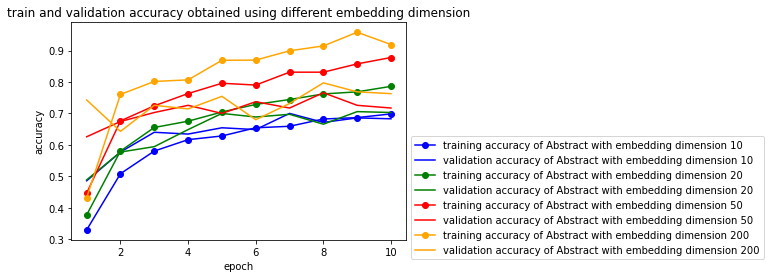

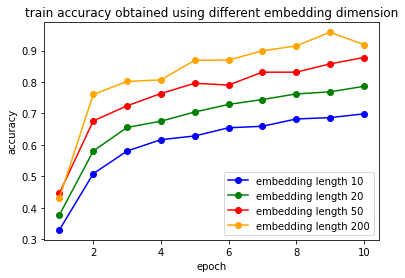

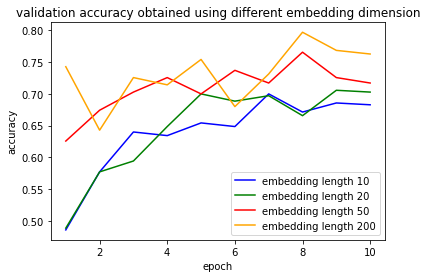

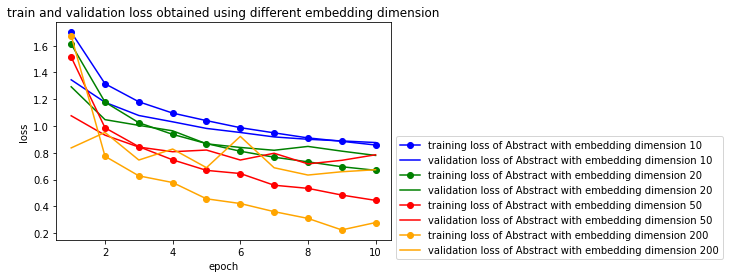

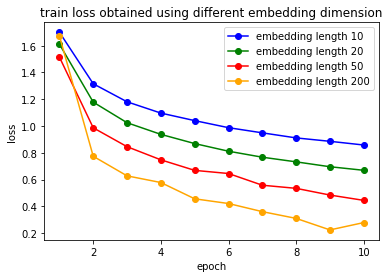

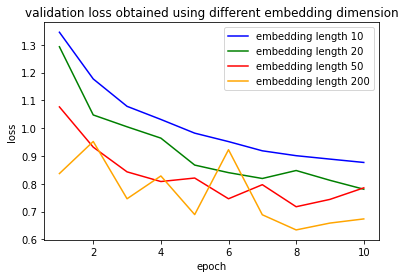

0

In [37]:
from gensim.models import Word2Vec
word2vec_history_list= []
# split into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(x_samples_seq_sub, y_samples_category_sub, test_size=0.1, random_state=37)
for embedding_dimension in embedding_dimension_list:
  emb_matrix_word2vec = np.zeros((NB_WORDS,embedding_dimension))
  model = Word2Vec(list(passage_samples.values()),sg=best_params['sg_cbow'], vector_size=embedding_dimension, window=best_params['window_size'], min_count=best_params['count_min'], negative=best_params['negative'], hs=best_params['hs'], workers=4)
  for w, i in tk_samples.word_index.items():
      # The word_index contains a token for all words of the training data so we need to limit that
      if i < NB_WORDS:
          vect = model.wv[w]
          # Check if the word from the training data occurs in the GloVe word embeddings
          # Otherwise the vector is kept with only zeros
          if vect is not None:
              emb_matrix_word2vec[i] = vect
      else:
          break
  X_train_trunc = pad_sequences(X_train, maxlen=100)
  X_test_trunc = pad_sequences(X_test, maxlen=100)
  word2vec_model = models.Sequential()
  word2vec_model.add(layers.Embedding(NB_WORDS, embedding_dimension, input_length=100))
  word2vec_model.add(layers.Flatten())
  word2vec_model.add(layers.Dense(7, activation='softmax'))
  word2vec_model.summary()
  word2vec_model.layers[0].set_weights([emb_matrix_word2vec])
  word2vec_model.layers[0].trainable = False
  word2vec_history = deep_model(word2vec_model, X_train_trunc, y_train, X_test_trunc, y_test)
  word2vec_history_list.append(word2vec_history)
  del X_train_trunc
  del X_test_trunc
  del emb_matrix_word2vec
  del word2vec_model
  K.clear_session()
best_embedding_length_word2vec = eval_metric(word2vec_history_list, 'accuracy', embedding_dimension_list, 1)
eval_metric(word2vec_history_list, 'loss',embedding_dimension_list, 1)

From the diagram, we can see that training accuracy increases with the embedding length.

tune the padding length of word2vec embedding and three layer neural network

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 200)          2000000   
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 7)                 140007    
                                                                 
Total params: 2,140,007
Trainable params: 2,140,007
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          2000000   
                                                                 
 flatten (Flatten)        

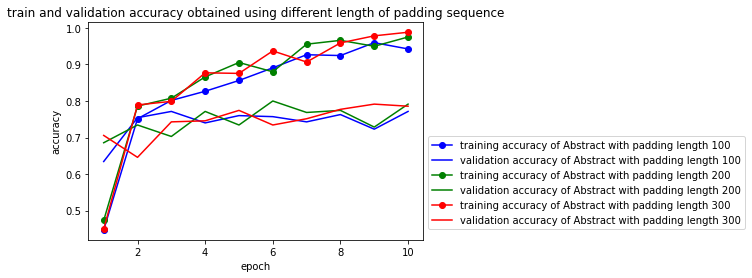

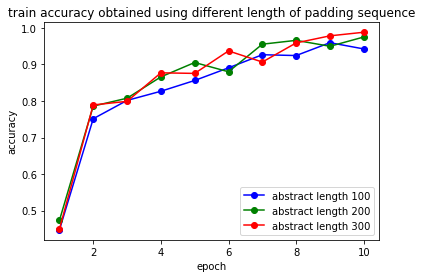

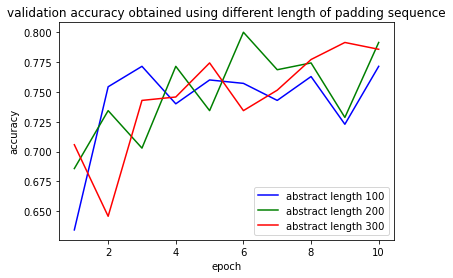

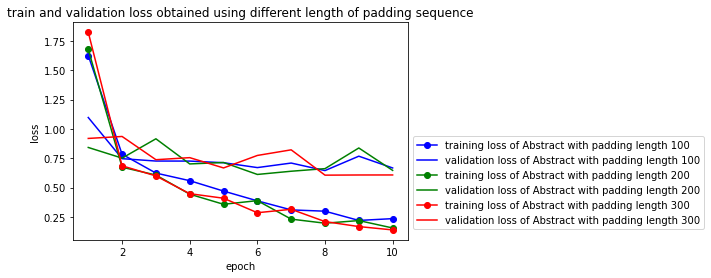

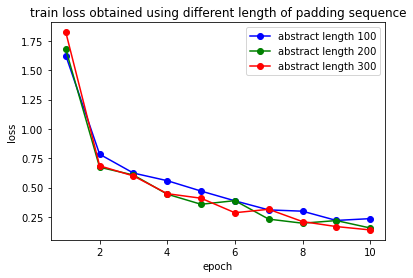

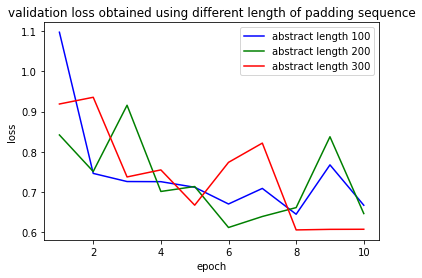

0

In [38]:
from gensim.models import Word2Vec
word2vec_history_list= []
emb_matrix_word2vec = np.zeros((NB_WORDS,best_embedding_length_word2vec))
model = Word2Vec(list(passage_samples.values()),sg=best_params['sg_cbow'], vector_size=best_embedding_length_word2vec, window=best_params['window_size'], min_count=best_params['count_min'], negative=best_params['negative'], hs=best_params['hs'], workers=4)
for w, i in tk_samples.word_index.items():
  # The word_index contains a token for all words of the training data so we need to limit that
  if i < NB_WORDS:
      vect = model.wv[w]
      # Check if the word from the training data occurs in the GloVe word embeddings
      # Otherwise the vector is kept with only zeros
      if vect is not None:
          emb_matrix_word2vec[i] = vect
  else:
      break
for MAX_LEN in MAX_LEN_list:
  X_train_trunc = pad_sequences(X_train, maxlen=MAX_LEN)
  X_test_trunc = pad_sequences(X_test, maxlen=MAX_LEN)
  word2vec_model = models.Sequential()
  word2vec_model.add(layers.Embedding(NB_WORDS, embedding_dimension, input_length=MAX_LEN))
  word2vec_model.add(layers.Flatten())
  word2vec_model.add(layers.Dense(7, activation='softmax'))
  word2vec_model.summary()
  word2vec_model.layers[0].set_weights([emb_matrix_word2vec])
  word2vec_model.layers[0].trainable = False
  word2vec_history = deep_model(word2vec_model, X_train_trunc, y_train, X_test_trunc, y_test)
  word2vec_history_list.append(word2vec_history)
  del X_train_trunc
  del X_test_trunc
  del word2vec_model
  K.clear_session()
best_abstract_length_word2vec = eval_metric(word2vec_history_list, 'accuracy', MAX_LEN_list, 0)
eval_metric(word2vec_history_list, 'loss',MAX_LEN_list, 0)

From the diagram, we can see that training accuracy is not quite related to the padding length

select the best parameters, best embedding length and best padding length to train word2vec embedding model and feed it to three layer neural network

In [39]:
model = Word2Vec(list(passage_samples.values()),sg=best_params['sg_cbow'], vector_size=best_embedding_length_word2vec, window=best_params['window_size'], min_count=best_params['count_min'], negative=best_params['negative'], hs=best_params['hs'], workers=4)
for w, i in tk_samples.word_index.items():
  # The word_index contains a token for all words of the training data so we need to limit that
  if i < NB_WORDS:
      vect = model.wv[w]
      # Check if the word from the training data occurs in the GloVe word embeddings
      # Otherwise the vector is kept with only zeros
      if vect is not None:
          emb_matrix_word2vec[i] = vect
  else:
      break
X_train_trunc_word2vec = pad_sequences(X_train, maxlen=best_abstract_length_word2vec)
X_test_trunc_word2vec = pad_sequences(X_test, maxlen=best_abstract_length_word2vec)
word2vec_model = models.Sequential()
word2vec_model.add(layers.Embedding(NB_WORDS, best_embedding_length_word2vec, input_length=best_abstract_length_word2vec))
word2vec_model.add(layers.Flatten())
word2vec_model.add(layers.Dense(7, activation='softmax'))
word2vec_model.summary()
word2vec_model.layers[0].set_weights([emb_matrix_word2vec])
word2vec_model.layers[0].trainable = False
word2vec_history = deep_model(word2vec_model, X_train_trunc_word2vec, y_train, X_test_trunc_word2vec, y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 200)          2000000   
                                                                 
 flatten (Flatten)           (None, 60000)             0         
                                                                 
 dense (Dense)               (None, 7)                 420007    
                                                                 
Total params: 2,420,007
Trainable params: 2,420,007
Non-trainable params: 0
_________________________________________________________________


Glove representation of word embedding, each word in the vocabulary is represented as a dense vector, the performace is similar with word2vec.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           500000    
                                                                 
 flatten_1 (Flatten)         (None, 5000)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 35007     
                                                                 
Total params: 535,007
Trainable params: 535,007
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)          

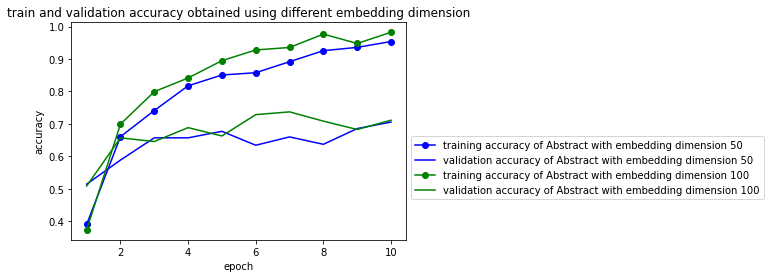

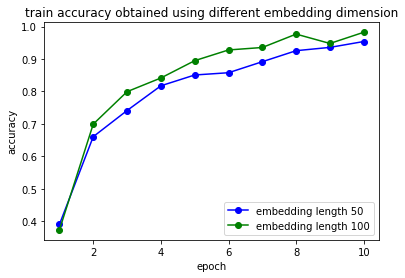

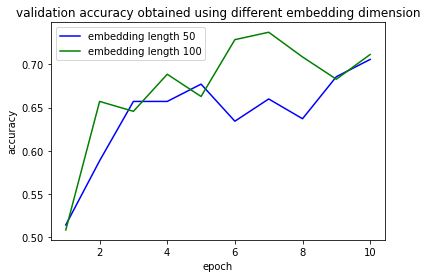

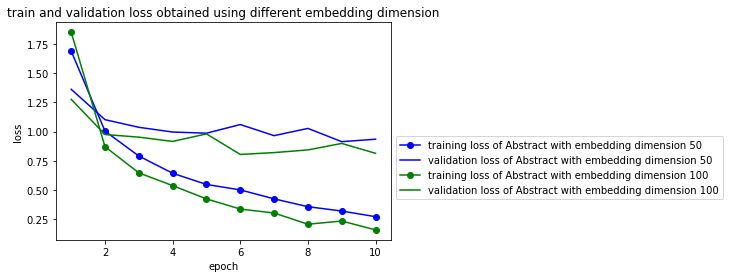

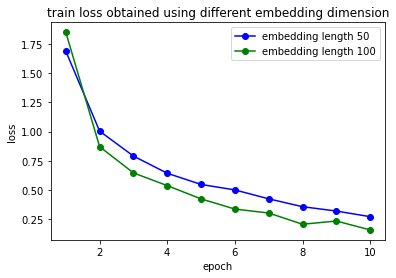

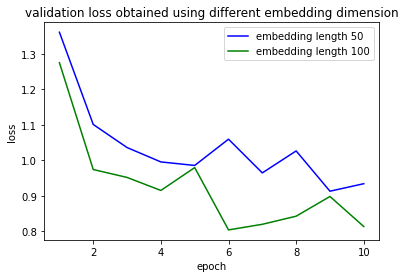

0

In [40]:
MAX_LEN_list = [100,200,300]
embedding_dimension_list = [50, 100]
glove_history_list= []
# pad the senquences to 100
X_train_trunc = pad_sequences(X_train, maxlen=100)
X_test_trunc = pad_sequences(X_test, maxlen=100)
#X_train, X_test, y_train, y_test = train_test_split(X_seq, y_category, test_size=0.1, random_state=37)
for embedding_dimension in embedding_dimension_list:
  emb_matrix = np.zeros((NB_WORDS, embedding_dimension))
  if embedding_dimension == 100:
    emb_dict = load_glove_vectors('glove.6B/glove.6B.100d.txt') #这些路径要改
  if embedding_dimension == 50:
    emb_dict = load_glove_vectors('glove.6B/glove.6B.50d.txt')
  if embedding_dimension == 200:
    emb_dict = load_glove_vectors('glove.6B/glove.6B.200d.txt')
  for w, i in tk_samples.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break
  glove_model = models.Sequential()
  glove_model.add(layers.Embedding(NB_WORDS, embedding_dimension, input_length=100))
  glove_model.add(layers.Flatten())
  glove_model.add(layers.Dense(7, activation='softmax'))
  glove_model.summary()
  glove_model.layers[0].set_weights([emb_matrix])
  glove_model.layers[0].trainable = False
  glove_history = deep_model(glove_model, X_train_trunc, y_train, X_test_trunc, y_test)
  glove_history_list.append(glove_history)
  del emb_matrix
  del glove_model
  K.clear_session()
del X_train_trunc
del X_test_trunc
best_embedding_length_glove = eval_metric(glove_history_list, 'accuracy', embedding_dimension_list, 1)
eval_metric(glove_history_list, 'loss',embedding_dimension_list, 1)

The model performance increases as the increasing embeddiing dimension

tune the padding length of Glove model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 7)                 70007     
                                                                 
Total params: 1,070,007
Trainable params: 1,070,007
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          1000000   
                                                                 
 flatten (Flatten)        

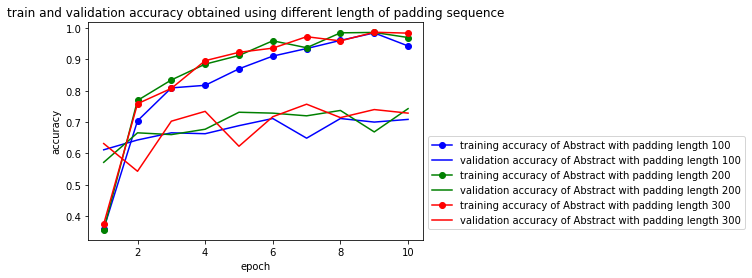

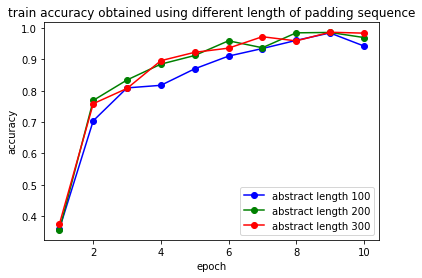

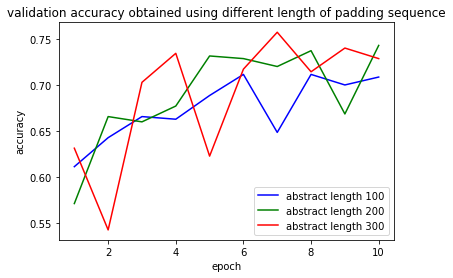

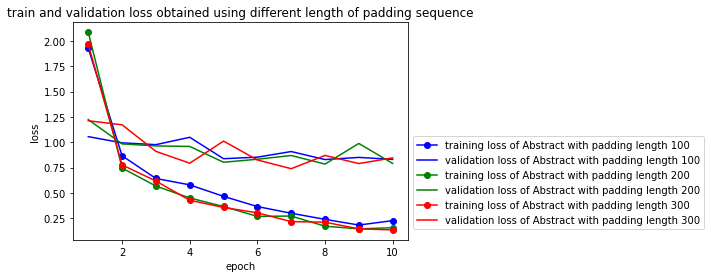

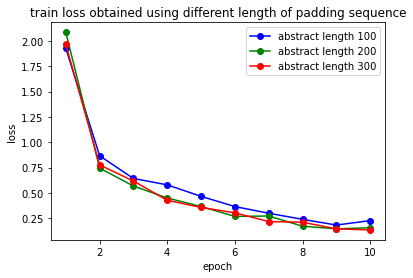

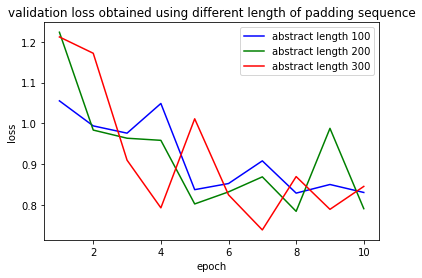

0

In [41]:
glove_history_list = []
emb_matrix = np.zeros((NB_WORDS, best_embedding_length_glove))
if best_embedding_length_glove == 100:
  emb_dict = load_glove_vectors('glove.6B/glove.6B.100d.txt') #这些路径要改
if best_embedding_length_glove == 50:
  emb_dict = load_glove_vectors('glove.6B/glove.6B.50d.txt')
for w, i in tk_samples.word_index.items():
  # The word_index contains a token for all words of the training data so we need to limit that
  if i < NB_WORDS:
      vect = emb_dict.get(w)
      # Check if the word from the training data occurs in the GloVe word embeddings
      # Otherwise the vector is kept with only zeros
      if vect is not None:
          emb_matrix[i] = vect
  else:
      break
for MAX_LEN in MAX_LEN_list:
  # pad the senquences to max length
  X_train_trunc = pad_sequences(X_train, maxlen=MAX_LEN)
  X_test_trunc = pad_sequences(X_test, maxlen=MAX_LEN)
  glove_model = models.Sequential()
  glove_model.add(layers.Embedding(NB_WORDS, embedding_dimension, input_length=MAX_LEN))
  glove_model.add(layers.Flatten())
  glove_model.add(layers.Dense(7, activation='softmax'))
  glove_model.summary()
  glove_model.layers[0].set_weights([emb_matrix])
  glove_model.layers[0].trainable = False
  glove_history = deep_model(glove_model, X_train_trunc, y_train, X_test_trunc, y_test)
  glove_history_list.append(glove_history)
  del X_train_trunc
  del X_test_trunc
  del glove_model
  K.clear_session()
best_abstract_length_glove = eval_metric(glove_history_list, 'accuracy', MAX_LEN_list, 0)
eval_metric(glove_history_list, 'loss',MAX_LEN_list, 0)

The padding length is not related to the model's performance

use the best embedding length and abstract length to train the model

In [42]:
emb_matrix = np.zeros((NB_WORDS, best_embedding_length_glove))
if best_embedding_length_glove == 100:
  emb_dict = load_glove_vectors('glove.6B/glove.6B.100d.txt')
if best_embedding_length_glove == 50:
  emb_dict = load_glove_vectors('glove.6B/glove.6B.50d.txt')
if best_embedding_length_glove == 200:
  emb_dict = load_glove_vectors('glove.6B/glove.6B.200d.txt')
for w, i in tk_samples.word_index.items():
  # The word_index contains a token for all words of the training data so we need to limit that
    if i < NB_WORDS:
      vect = emb_dict.get(w)
      # Check if the word from the training data occurs in the GloVe word embeddings
      # Otherwise the vector is kept with only zeros
      if vect is not None:
          emb_matrix[i] = vect
    else:
      break
# pad the senquences to max length
X_train_trunc_glove = pad_sequences(X_train, maxlen=best_abstract_length_glove)
X_test_trunc_glove = pad_sequences(X_test, maxlen=best_abstract_length_glove)
glove_model = models.Sequential()
glove_model.add(layers.Embedding(NB_WORDS, best_embedding_length_glove, input_length=best_abstract_length_glove))
glove_model.add(layers.Flatten())
glove_model.add(layers.Dense(7, activation='softmax'))
glove_model.summary()
glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = False
glove_history = deep_model(glove_model, X_train_trunc_glove, y_train, X_test_trunc_glove, y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 7)                 210007    
                                                                 
Total params: 1,210,007
Trainable params: 1,210,007
Non-trainable params: 0
_________________________________________________________________


We apply CNN method for text classification, which inputs the feature matrix into multiple convolutional layers with different filter sizes and feeds the result into corresponding max-pooling layer, then flattens the connected largest features and passes it to a dropout layer, which will randomly drop out half of the nodes. A dense layer with softmax activation function will output the probabilities of passages belonging to each category.


In [43]:
import tensorflow as tf
class TextCNN(tf.keras.Model):
    def __init__(self, num_classes,vector_size, abstract_length,filter_sizes=[2,3,4], num_filters=128, method ="word2vec", **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        if method == "word2vec":
          self.embedding_layer = tf.keras.layers.Embedding(NB_WORDS, vector_size, input_length=abstract_length, weights=[emb_matrix_word2vec])
        elif method == "glove":
          self.embedding_layer = tf.keras.layers.Embedding(NB_WORDS, vector_size, input_length=abstract_length, weights=[emb_matrix])
        else:
          self.embedding_layer = tf.keras.layers.Embedding(NB_WORDS, vector_size, input_length=abstract_length)
        self.conv_layers = [tf.keras.layers.Conv2D(num_filters, (filter_size, vector_size), activation='relu',bias_initializer=tf.keras.initializers.Constant(0.1),)
                            for filter_size in filter_sizes]
        self.pool_layers = [tf.keras.layers.MaxPool2D((abstract_length - filter_size + 1, 1))
                            for filter_size in filter_sizes]
        self.flatten_layer = tf.keras.layers.Flatten()
        self.dropout_layer = tf.keras.layers.Dropout(0.5)
        self.dense_layer = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_initializer='glorot_normal', bias_initializer=tf.keras.initializers.Constant(0.1))

    def call(self, inputs):
        embedding = tf.expand_dims(self.embedding_layer(inputs),-1)
        pool_array = []
        for conv_layer, pool_layer in zip(self.conv_layers, self.pool_layers):
            conv_out = conv_layer(embedding)
            pool_out = pool_layer(conv_out)
            pool_array.append(pool_out)
        h_pool = tf.concat(pool_array, 3)
        h_pool_flat = self.flatten_layer(h_pool)
        h_drop = self.dropout_layer(h_pool_flat)
        scores = self.dense_layer(h_drop)
        return scores

In [44]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
cnn_group = []
history = []
# complete the training for three trials, the word embedding method is glove ,word2vec and random respectively
for method in ["glove","word2vec","random"]:
  if method == "glove":
    best_abstract_length = best_abstract_length_glove
    best_embedding_length = best_embedding_length_glove
  if method == "word2vec":
    best_abstract_length = best_abstract_length_word2vec
    best_embedding_length = best_embedding_length_word2vec
  if method == "random":
    best_abstract_length = best_abstract_length_random
    best_embedding_length = best_embedding_length_random
  cnn = TextCNN(num_classes=7, vector_size = best_embedding_length, abstract_length = best_abstract_length, method = method)
  # Define loss function, optimizer and metrics
  cnn.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
  # Train the model
  if method == "glove":
    X_train_trunc_glove = pad_sequences(X_train_5000, maxlen=best_abstract_length_glove)
    X_test_trunc_glove = pad_sequences(X_test_5000, maxlen=best_abstract_length_glove)
    history_glove = cnn.fit(X_train_trunc_glove, y_train_5000, epochs=5, validation_data=(X_test_trunc_glove, y_test_5000))
    history.append(history_glove)
  if method == "word2vec":
    X_train_trunc_word2vec = pad_sequences(X_train_5000, maxlen=best_abstract_length_word2vec)
    X_test_trunc_word2vec = pad_sequences(X_test_5000, maxlen=best_abstract_length_word2vec)
    history_word2vec = cnn.fit(X_train_trunc_word2vec, y_train_5000, epochs=5, validation_data=(X_test_trunc_word2vec, y_test_5000))
    history.append(history_word2vec)
  if method == "random":
    # pad the senquences to max length
    X_train_trunc_random = pad_sequences(X_train_5000, maxlen=best_abstract_length_random)
    X_test_trunc_random = pad_sequences(X_test_5000, maxlen=best_abstract_length_random)
    history_random = cnn.fit(X_train_trunc_random, y_train_5000, epochs=5, validation_data=(X_test_trunc_random, y_test_5000))
    history.append(history_random)
  cnn_group.append(cnn)

Epoch 1/5
963/963 [==============================] - 70s 70ms/step - loss: 0.9225 - accuracy: 0.6692 - val_loss: 0.5152 - val_accuracy: 0.8195
Epoch 2/5
963/963 [==============================] - 79s 83ms/step - loss: 0.4629 - accuracy: 0.8419 - val_loss: 0.4279 - val_accuracy: 0.8531
Epoch 3/5
963/963 [==============================] - 79s 82ms/step - loss: 0.3573 - accuracy: 0.8788 - val_loss: 0.4071 - val_accuracy: 0.8581
Epoch 4/5
963/963 [==============================] - 78s 81ms/step - loss: 0.2796 - accuracy: 0.9036 - val_loss: 0.4121 - val_accuracy: 0.8589
Epoch 5/5
963/963 [==============================] - 75s 78ms/step - loss: 0.2188 - accuracy: 0.9238 - val_loss: 0.4403 - val_accuracy: 0.8537
Epoch 1/5
963/963 [==============================] - 143s 147ms/step - loss: 0.7451 - accuracy: 0.7395 - val_loss: 0.4140 - val_accuracy: 0.8575
Epoch 2/5
963/963 [==============================] - 131s 136ms/step - loss: 0.3785 - accuracy: 0.8713 - val_loss: 0.3802 - val_accuracy: 0.

plot training and validation accuracy for Glove, Word2vec and random word embedding with TextCNN

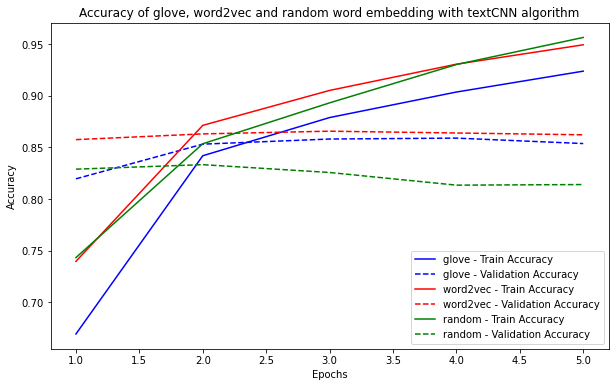

In [45]:
import matplotlib.pyplot as plt

# Assuming you have a list 'history_list' containing three history dictionaries
# history_list = [history1, history2, history3]

method_names = ["glove","word2vec","random"]
colors = ['b', 'r', 'g']

plt.figure(figsize=(10, 6))

for idx, h in enumerate(history):
    train_accuracy = h.history['accuracy']
    val_accuracy = h.history['val_accuracy']
    num = range(1, len(train_accuracy) + 1)

    plt.plot(num, train_accuracy, colors[idx], label=f'{method_names[idx]} - Train Accuracy')
    plt.plot(num, val_accuracy, colors[idx]+'--', label=f'{method_names[idx]} - Validation Accuracy')

plt.title('Accuracy of glove, word2vec and random word embedding with textCNN algorithm')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


construct the testing dataset

In [46]:
text = "Background To gain maximum insight from large administrative healthcare datasets it is important to understand their data quality. Although a gold standard against which to assess criterion validity rarely exists for such datasets, internal consistency can be evaluated. We aimed to identify inconsistencies in the recording of mandatory International Statistical Classification of Diseases and Related Health Problems, tenth revision (ICD- 10) codes within the Hospital Episodes Statistics dataset in England. Methods Three exemplar medical conditions where recording is mandatory once diagnosed were chosen: autism, type II diabetes mellitus and Parkinson’s disease dementia. We identified the first occurrence of the condition ICD-10 code for a patient during the period April 2013 to March 2021 and in subsequent hospital spells. We designed and trained random forest classifiers to identify variables strongly associated with recording inconsistencies. Results For autism, diabetes and Parkinson’s disease dementia respectively, 43.7%, 8.6% and 31.2% of subsequent spells had inconsistencies. Coding inconsistencies were highly correlated with non-coding of an underlying condition, a change in hospital trust and greater time between the spell with the first coded diagnosis and the subsequent spell. For patients with diabetes or Parkinson’s disease dementia, the code recording for spells without an overnight stay were found to have a higher rate of inconsistencies. Conclusions Data inconsistencies are relatively common for the three conditions considered. Where these mandatory diagnoses are not recorded in administrative datasets, and where clinical decisions are made based on such data, there is potential for this to impact patient care."

In [47]:
text1 = "Introduction Large healthcare datasets can provide insight that has the potential to improve outcomes for patients. However, it is important to understand the strengths and limitations of such datasets so that the insights they provide are accurate and useful. The aim of this study was to identify data inconsistencies within the Hospital Episodes Statistics (HES) dataset for autistic patients and assess potential biases introduced through these inconsistencies and their impact on patient outcomes. The study can only identify inconsistencies in recording of autism diagnosis and not whether the inclusion or exclusion of the autism diagnosis is the error. Data were extracted from the HES database for the period 1st April 2013 to 31st March 2021 for patients with a diagnosis of autism. First spells in hospital during the study period were identified for each patient and these were linked to any subsequent spell in hospital for the same patient. Data inconsistencies were recorded where autism was not recorded as a diagnosis in a subsequent spell. Features associated with data inconsistencies were identified using a random forest classifiers and regression modelling. Results Data were available for 172,324 unique patients who had been recorded as having an autism diagnosis on first admission. In total, 43.7 % of subsequent spells were found to have inconsistencies. The features most strongly associated with inconsistencies included greater age, greater deprivation, longer time since the first spell, change in provider, shorter length of stay, being female and a change in the main specialty description. The random forest algorithm had an area under the receiver operating characteristic curve of 0.864 in predicting a data inconsistency. For patients who died in hospital, inconsistencies in their final spell were significantly associated with being 80 years and over, being female, greater deprivation and use of a palliative care code in the death spell. conclusions Data inconsistencies in the HES database were relatively common in autistic patients and were associated a number of patient and hospital admission characteristics. Such inconsistencies have the potential to distort our understanding of service use in key demographic groups."

In [48]:
text2 = "The contraction of the heart muscle is triggered by self-organizing electrical patterns. Abnormalities in these patterns lead to cardiac arrhythmias, a prominent cause of mortality worldwide. The targeted treatment or prevention of arrhythmias requires a thorough understanding of the interacting wavelets, vortices and conduction block sites within the excitation pattern. Currently, there is no conceptual framework that covers the elementary processes during arrhythmogenesis in detail, in particular the transient pivoting patterns observed in patients, which can be interleaved with periods of less fragmented waves. Here, we provide such a framework in terms of quasiparticles and Feynman diagrams, which were originally developed in theoretical physics. We identified three different quasiparticles in excitation patterns: heads, tails and pivots. In simulations and experiments, we show that these basic building blocks can combine into at least four different bound states. By representing their interactions as Feynman diagrams, the creation and annihilation of rotor pairs are shown to be sequences of dynamical creation, annihilation and recombination of the identified quasiparticles. Our results provide a new theoretical foundation for a more detailed theory, analysis and mechanistic insights of topological transitions in excitation patterns, to be applied within and beyond the context of cardiac electrophysiology."

In [49]:
text3 = "The COVID-19 pandemic has created unprecedented challenges for governments and healthcare systems worldwide, highlighting the critical importance of understanding the factors that contribute to virus transmission. This study aimed to identify the most influential age groups in COVID-19 infection rates at the US county level using the Modified Morris Method and deep learning for time series. Our approach involved training the state-of-the-art time-series model Temporal Fusion Transformer on different age groups as a static feature and the population vaccination status as the dynamic feature. We analyzed the impact of those age groups on COVID-19 infection rates by perturbing individual input features and ranked them based on their Morris sensitivity scores, which quantify their contribution to COVID-19 transmission rates. The findings are verified using ground truth data from the CDC and US Census, which provide the true infection rates for each age group. The results suggest that young adults were the most influential age group in COVID-19 transmission at the county level between March 1, 2020, and November 27, 2021. Using these results can inform public health policies and interventions, such as targeted vaccination strategies, to better control the spread of the virus. Our approach demonstrates the utility of feature sensitivity analysis in identifying critical factors contributing to COVID-19 transmission and can be applied in other public health domains."

In [50]:
text4 = "We show that the transformation of a time-evolving spherically symmetric metric tensor into a Painleve-Gullstrand-Lemaitre form brings forth a few curious consequences. The time evolution describes a non-singular gravitational collapse, leading to a bounce and dispersal of all the clustered matter, or a wormhole geometry for certain initial conditions. The null convergence condition is violated only at the onset of bounce or the wormhole formation. As an example, the requirements to develop a Simpson-Visser wormhole/regular black-hole geometry is discussed. The solution can be regarded as a new time-evolving twin of sonic dumb holes found in analog gravity."

In [51]:
text5 = "The advancement of neutrino observatories has sparked a surge in multi-messenger astronomy. Multiple neutrino associations among blazars are reported while neutrino production sites are located within their central (sub)parsecs. Yet, many questions remain on the nature of those processes. The next generation Event Horizon Telescope (ngEHT) is uniquely positioned for these studies, as its high frequency and resolution can probe both the accretion disk region and the parsec-scale jet. This opens up new opportunities for connecting the two regions and unraveling the proton acceleration and neutrino production in blazars. We outline observational strategies for ngEHT and highlight what it can contribute to the multi-messenger study of blazars."

In [52]:
text6 = "A challenging aspect of the description of a tokamak disruption is evaluating the hot tail runaway electron (RE) seed that emerges during the thermal quench. This problem is made challenging due to the requirement of describing a strongly non-thermal electron distribution, together with the need to incorporate a diverse range of multiphysics processes including magnetohydrodynamic instabilities, impurity transport, and radiative losses. The present work develops a physics-informed neural network (PINN) tailored to the solution of the hot tail seed during an idealized axisymmetric thermal quench. Here, a PINN is developed to identify solutions to the adjoint relativistic Fokker-Planck equation in the presence of a rapid quench of the plasma's thermal energy. It is shown that the PINN is able to accurately predict the hot tail seed across a range of parameters including the thermal quench time scale, initial plasma temperature, and local current density, in the absence of experimental or simulation data. The hot tail PINN is verified by comparison with a direct Monte Carlo solution, with excellent agreement found across a broad range of thermal quench conditions."

In [53]:
text7 = "Entropy measures quantify the amount of information and correlations present in a quantum system. In practice, when the quantum state is unknown and only copies thereof are available, one must resort to the estimation of such entropy measures. Here we propose a variational quantum algorithm for estimating the von Neumann and Rényi entropies, as well as the measured relative entropy and measured Rényi relative entropy. Our approach first parameterizes a variational formula for the measure of interest by a quantum circuit and a classical neural network, and then optimizes the resulting objective over parameter space. Numerical simulations of our quantum algorithm are provided, using a noiseless quantum simulator. The algorithm provides accurate estimates of the various entropy measures for the examples tested, which renders it as a promising approach for usage in downstream tasks."

In [54]:
text8 = "The formation history of giant planets inside and outside the solar system remains unknown. We suggest that runaway gas accretion is initiated only at a mass of ~100 M_Earth and that this mass corresponds to the transition to a gas giant, a planet that its composition is dominated in hydrogen and helium. Delaying runaway accretion to later times (a few Myr) and higher masses is likely to be a result of an intermediate stage of efficient heavy-element accretion (at a rate of ~10^-5 M_Earth/yr) that provides sufficient energy to hinder rapid gas accretion. This may imply that Saturn has never reached runaway gas accretion, and that it is a failed giant planet. The transition to a gas giant planet above Saturn's mass naturally explains the differences between the bulk metallicities and internal structures of Jupiter and Saturn. The transition mass to a gas giant planets strongly depends on the exact formation history and birth environment of the planets, which are still not well constrained for our Solar System. In terms of giant exoplanets, delaying runaway gas accretion to planets beyond Saturn's mass can explain the transitions in the mass-radius relations of observed exoplanets and the high metallicity of intermediate-mass exoplanets."

In [55]:
text9 = "Observed scaling relations in galaxies between baryons and dark matter global properties are key to shed light on the process of galaxy formation and on the nature of dark matter. Here, we study the scaling relation between the neutral hydrogen (HI) and dark matter mass in isolated rotationally-supported disk galaxies at low redshift. We first show that state-of-the-art galaxy formation simulations predict that the HI-to-dark halo mass ratio decreases with stellar mass for the most massive disk galaxies. We then infer dark matter halo masses from high-quality rotation curve data for isolated disk galaxies in the local Universe, and report on the actual universality of the HI-to-dark halo mass ratio for these observed galaxies. This scaling relation holds for disks spanning a range of 4 orders of magnitude in stellar mass and 3 orders of magnitude in surface brightness. Accounting for the diversity of rotation curve shapes in our observational fits decreases the scatter of the HI-to-dark halo mass ratio while keeping it constant. This finding extends the previously reported discrepancy for the stellar-to-halo mass relation of massive disk galaxies within galaxy formation simulations to the realm of neutral atomic gas. Our result reveals that isolated galaxies with regularly rotating extended HI disks are surprisingly self-similar up to high masses, which hints at mass-independent self-regulation mechanisms that have yet to be fully understood."

In [56]:
test_dataset = []
test_dataset.append(text)
test_dataset.append(text1)
test_dataset.append(text2)
test_dataset.append(text3)
test_dataset.append(text4)
test_dataset.append(text5)
test_dataset.append(text6)
test_dataset.append(text7)
test_dataset.append(text8)
test_dataset.append(text9)

clean the testing dataset and convert text to numerical sequence using training dataset tokenizer

In [57]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [58]:
x_clean = [re.sub(r'[^a-zA-Z\s]', u'',sentence.replace('\n', ''), flags=re.UNICODE) for sentence in test_dataset]
x_clean = [' '.join(list(filter(lambda w: w not in stop_words and len(w)>2, map(lemmatizer.lemmatize, sentence.lower().split())))) for sentence in x_clean]
x_clean_array = [list(filter(lambda w: w not in stop_words and len(w)>2, map(lemmatizer.lemmatize, sentence.lower().split()))) for sentence in x_clean]

# convert text to sequence
X_seq_test = tk.texts_to_sequences(x_clean_array)
X_seq_test_sample = tk_samples.texts_to_sequences(x_clean_array)

construct the embedding of labels medical, astronomy, physics and computer science using Glove embedding

In [59]:
labels = ['medical','astronomy','physics','computer science']

In [60]:
word_vectors = load_glove_vectors('glove.6B/glove.6B.100d.txt')

In [61]:
label_embedding_array = []
for label in labels:
  label_array = label.split()
  if len(label_array) == 1:
    label_embedding = word_vectors[label]
  else:
    label_embedding = np.sum([word_vectors[label] for label in label_array], axis = 0)/len(label_array)
  label_embedding_array.append(label_embedding)

use the same way to construct the embedding of words in testing datasets

In [62]:
test_embedding = []
for data in x_clean_array:
  filtered_words = [word for word in data if word in word_vectors]
  test_embedding.append(np.sum([word_vectors[word] for word in filtered_words],axis=0)/len(filtered_words))

calculate the cosine similarity between the label embedding and testing datasets embedding

In [63]:
def cosine_similarity(x, y):
  dot_product = np.dot(x, y)
  norm_x = np.linalg.norm(x)
  norm_y = np.linalg.norm(y)
  similarity = dot_product / (norm_x * norm_y)
  return similarity
prediction_array = []
for test_passage in test_embedding:
  largest_similarity = 0
  i = 0
  for label in label_embedding_array:
    if largest_similarity < cosine_similarity(test_passage, label):
      largest_similarity = cosine_similarity(test_passage, label)
      predicted_label = labels[i]
    i+=1
  prediction_array.append(predicted_label)
print(prediction_array)

['medical', 'medical', 'computer science', 'computer science', 'computer science', 'computer science', 'computer science', 'computer science', 'computer science', 'computer science']


predict based on the frequency of each word in the testing dataset occurs in the training dataset

In [64]:
target_label = ["CS", "astronomy","biochemistry","psychology","medical","physics","civilization engineering"]
for x in x_clean_array:
  max_length = 0
  max_index = 0
  for j in range(len(vocabulary_array)):
    indices = [i for i, word in enumerate(x) if word in vocabulary_array[j]]
    if np.sum(np.array(word_counts_array[j])[indices]) > max_length:
      max_length = np.sum(np.array(word_counts_array[j])[indices])
      max_index = j
  print(target_label[max_index])

medical
medical
medical
medical
medical
medical
medical
medical
medical
medical


It can be seen that all testing dataset has been predicted as one category, one probable reason is that this category contains more frequent used words that appear in every testing Abstracts

predict based on number of occurances of each bigram in the testing dataset in the training dataset

In [68]:
bigram_class = ["CS","astronomy","physics","civil","medical","psychology","biochemistry"]
for tokens in x_clean_array:
  pos_tags = pos_tag(tokens)
  filtered_words = [word for word, pos in pos_tags if pos != 'VB' and pos != 'VBD' and pos != 'VBG' and pos != 'VBN' and pos != 'VBP' and pos != 'VBZ']
  total_CS = np.sum([CS_counts[bigram] for bigram in nltk.bigrams(filtered_words) if bigram in CS_counts.keys()])
  total_astronomy = np.sum([astronomy_counts[bigram] for bigram in nltk.bigrams(filtered_words) if bigram in astronomy_counts.keys()])
  total_physics = np.sum([physics_counts[bigram] for bigram in nltk.bigrams(filtered_words) if bigram in physics_counts.keys()])
  total_civil = np.sum([Civil_counts[bigram] for bigram in nltk.bigrams(filtered_words) if bigram in Civil_counts.keys()])
  total_Medical = np.sum([Medical_counts[bigram] for bigram in nltk.bigrams(filtered_words) if bigram in Medical_counts.keys()])
  total_Psychology = np.sum([Psychology_counts[bigram] for bigram in nltk.bigrams(filtered_words) if bigram in Psychology_counts.keys()])
  total_biochemistry = np.sum([biochemistry_counts[bigram] for bigram in nltk.bigrams(filtered_words) if bigram in biochemistry_counts.keys()])
  print(bigram_class[np.argmax([total_CS, total_astronomy, total_physics, total_civil, total_Medical, total_Psychology, total_biochemistry])])

medical
medical
physics
medical
astronomy
astronomy
CS
physics
astronomy
astronomy


Surprisingly, the result of this method is very accurate, only one of the predictions is wrong, the seventh Abstract, which should be predicted as physics category, misclassified as CS, the high accuracy suggests that measuring co-occurance bigram is efficient.

prediction of testing abstract category using simple three layer neural network with randomly generated word embedding method

In [69]:
X_seq_test_trunc = pad_sequences(X_seq_test, maxlen=best_abstract_length_random)
predictions = m.predict(X_seq_test_trunc)
for prediction in predictions:
  index = np.argmax(prediction)
  for key,value in label_mapping.items():
      if index == value:
        print(key)
        break

1/1 [==============================] - 0s 295ms/step
Medical
CS
physics
CS
astronomy
astronomy
astronomy
physics
astronomy
astronomy


prediction of testing abstract category using simple three layer neural network with glove word embedding method

In [70]:
X_seq_test_trunc = pad_sequences(X_seq_test_sample, maxlen=best_abstract_length_glove)
predictions = glove_model.predict(X_seq_test_trunc)
for prediction in predictions:
  index = np.argmax(prediction)
  for key,value in label_mapping.items():
      if index == value:
        print(key)
        break

1/1 [==============================] - 0s 164ms/step
Psychology
Psychology
Psychology
Psychology
physics
astronomy
Civil
CS
astronomy
astronomy


prediction of testing abstract category using simple three layer neural network with word2vec word embedding method

In [71]:
X_seq_test_trunc = pad_sequences(X_seq_test_sample, maxlen=best_abstract_length_word2vec)
predictions = word2vec_model.predict(X_seq_test_trunc)
for prediction in predictions:
  index = np.argmax(prediction)
  for key,value in label_mapping.items():
      if index == value:
        print(key)
        break

1/1 [==============================] - 0s 141ms/step
Medical
Medical
Civil
Medical
physics
astronomy
Civil
CS
astronomy
astronomy


random generation performs best since it avoids overfitting, which occurs significantly in word2vec and glove.

textCNN prediction of testing abstract using glove, word2vec, random generation as word embedding method

In [72]:
predicted_labels_cnn = []
for i in range(len(cnn_group)):
  if i == 0:
    best_abstract_length = best_abstract_length_glove
  if i == 1:
    best_abstract_length = best_abstract_length_word2vec
  if i == 2:
    best_abstract_length = best_abstract_length_random
  X_seq_test_trunc = pad_sequences(X_seq_test, maxlen=best_abstract_length)
  predictions = cnn_group[i].predict(X_seq_test_trunc)
  indexes = np.argmax(predictions, axis=1)
  predicted_labels_cnn.append(indexes)
  for index in indexes:
    for key,value in label_mapping.items():
        if index == value:
          print(key)
          break

1/1 [==============================] - 0s 204ms/step
Medical
Psychology
physics
Psychology
astronomy
astronomy
astronomy
physics
astronomy
astronomy
1/1 [==============================] - 0s 194ms/step
Medical
Civil
physics
Psychology
astronomy
astronomy
astronomy
physics
astronomy
astronomy
1/1 [==============================] - 0s 134ms/step
Medical
Medical
physics
CS
astronomy
astronomy
physics
physics
astronomy
astronomy


# Random Forest


construct word embedding of training and testing dataset

In [73]:
# testing dataset
x_test = []
for tokens in x_clean_array:
  filtered_words = [word for word in tokens if word in model.wv.key_to_index]
  x_test.append(np.sum(model.wv[filtered_words],axis=0)/len(filtered_words))
# training dataset
passages_vector_2d = []
for data in passage_samples.values():
  filtered_words = [word for word in data if word in model.wv.key_to_index]
  passages_vector_2d.append(np.sum(model.wv[filtered_words],axis=0)/len(filtered_words))

use random search to replace grid search to find the best set of parameters, since grid search will take a large amount of time, we try for 50 parameter combinations and print out the best parameter set and accuracy score.

In [74]:
from sklearn.model_selection import RandomizedSearchCV
# parameter distribution
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [50, 100, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier = RandomForestClassifier(n_jobs=-1)

# random search with RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_classifier,
                                   param_distributions=param_grid,
                                   n_iter=50,  # try 50 parameters combination
                                   cv=5,
                                   random_state=42,
                                   n_jobs=-1)

random_search.fit(passages_vector_2d, y_encoded_samples)
# Access the results
results = random_search.cv_results_
params_list = results['params']
mean_test_scores = results['mean_test_score']
for params, score in zip(params_list, mean_test_scores):
    print("Parameters:", params)
    print("Score:", score)
    print("------------------")
# find the best parameters and the best accuracy
chosen_parameter = random_search.best_params_
chosen_score = random_search.best_score_
print("Best Parameters:", chosen_parameter)
print("Best Score:", chosen_score)

Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 100}
Score: 0.7902857142857143
------------------
Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50}
Score: 0.7834285714285714
------------------
Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 50}
Score: 0.785142857142857
------------------
Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 100}
Score: 0.7874285714285714
------------------
Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 50}
Score: 0.7802857142857142
------------------
Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 100}
Score: 0.7894285714285714
------------------
Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 50}
Score: 0.7902857142857143
----------------

analyze the correlation between each parameter and accuracy to determine the effect of each parameter to the accuracy

In [75]:
n_estimators_list = [d['n_estimators'] for d in params_list]
max_depth_list = [d['max_depth'] for d in params_list]
min_samples_split_list = [d['min_samples_split'] for d in params_list]
min_samples_leaf_list = [d['min_samples_leaf'] for d in params_list]
correlation_n_estimators, p_value = spearmanr(n_estimators_list, mean_test_scores)
correlation_mean_samples_split, p_value = spearmanr(min_samples_split_list, mean_test_scores)
correlation_mean_samples_leaf, p_value = spearmanr(min_samples_leaf_list, mean_test_scores)
correlation_max_depth, p_value = spearmanr(max_depth_list, mean_test_scores)
print("correlation between n_estimators and accuracy is ",correlation_n_estimators)
print("correlation between min sample split and accuracy is", correlation_mean_samples_split)
print("correlation between min sample leaf and accuracy is", correlation_mean_samples_leaf)
print("correlation between max depth and accuracy is", correlation_max_depth)

correlation between n_estimators and accuracy is  0.3348561562932179
correlation between min sample split and accuracy is -0.1563028436315398
correlation between min sample leaf and accuracy is -0.18783145481581773
correlation between max depth and accuracy is 0.3005510247752729


We can see that n_estimators have the largest positive correlation with the accuracy, suggesting that as the number of decison tree increases for voting, the accuracy will increase at the same time. The min sample in the leaf node has negative correlation with the accuracy, indicating that the accuracy will increase the number of samples in the leaf node decreases

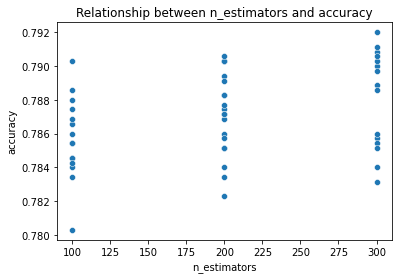

In [76]:
import seaborn as sns
df = pd.DataFrame({
    'n_estimators': n_estimators_list,
    'accuracy': mean_test_scores
})

sns.scatterplot(data=df, x='n_estimators', y='accuracy')
plt.title("Relationship between n_estimators and accuracy")
plt.show()


From the graph, you can see that accuracy increases as the increasing of number of estimators.

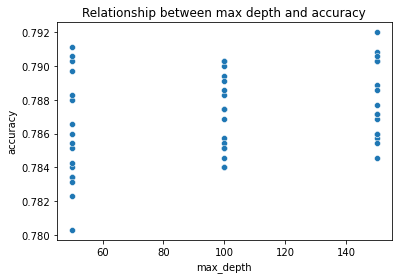

In [77]:
df = pd.DataFrame({
    'max_depth': max_depth_list,
    'accuracy': mean_test_scores
})

sns.scatterplot(data=df, x='max_depth', y='accuracy')
plt.title("Relationship between max depth and accuracy")
plt.show()

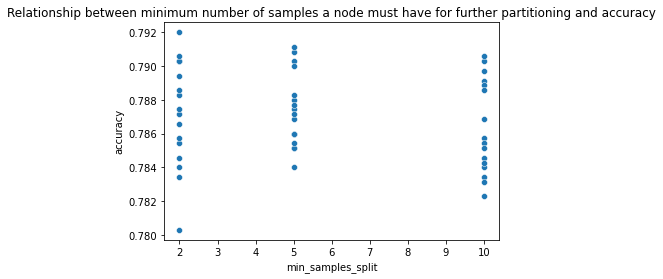

In [78]:
df = pd.DataFrame({
    'min_samples_split': min_samples_split_list,
    'accuracy': mean_test_scores
})

sns.scatterplot(data=df, x='min_samples_split', y='accuracy')
plt.title("Relationship between minimum number of samples a node must have for further partitioning and accuracy")
plt.show()

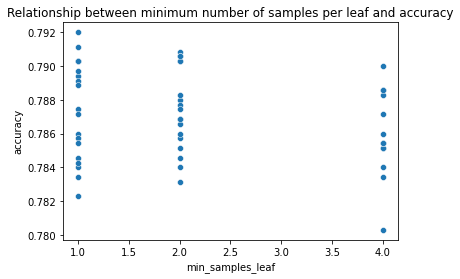

In [79]:
df = pd.DataFrame({
    'min_samples_leaf': min_samples_leaf_list,
    'accuracy': mean_test_scores
})

sns.scatterplot(data=df, x='min_samples_leaf', y='accuracy')
plt.title("Relationship between minimum number of samples per leaf and accuracy")
plt.show()

classify the abstracts using random forest classifier with word2vec word embedding method

In [80]:
passages_vector_2d = []
for data in passage.values():
  filtered_words = [word for word in data if word in model.wv.key_to_index]
  passages_vector_2d.append(np.sum(model.wv[filtered_words],axis=0)/len(filtered_words))
random_forest = RandomForestClassifier(n_estimators=chosen_parameter['n_estimators'], max_depth=chosen_parameter['max_depth'],min_samples_split=chosen_parameter['min_samples_split'],min_samples_leaf=chosen_parameter['min_samples_leaf'],n_jobs=-1)
random_forest.fit(passages_vector_2d, y_encoded)

RandomForestClassifier(max_depth=150, n_estimators=300, n_jobs=-1)

In [81]:
predicted_labels_rf_word2vec = random_forest.predict(x_test)
for label in predicted_labels_rf_word2vec:
  for key,value in label_mapping.items():
    if label == value:
      print(key)
      break

Medical
Medical
physics
Medical
physics
astronomy
astronomy
physics
astronomy
astronomy


random forest and glove word embedding

In [82]:
if best_embedding_length_glove == 100:
  emb_dict = load_glove_vectors('glove.6B/glove.6B.100d.txt')
if best_embedding_length_glove == 50:
  emb_dict = load_glove_vectors('glove.6B/glove.6B.50d.txt')
passages_vector_2d_glove = []
for data in passage.values():
  filtered_words = [word for word in data if word in emb_dict]
  passages_vector_2d_glove.append(np.sum([emb_dict[word] for word in filtered_words],axis=0)/len(filtered_words))
x_test_glove = []
for tokens in x_clean_array:
  filtered_words = [word for word in tokens if word in emb_dict]
  x_test_glove.append(np.sum([emb_dict[word] for word in filtered_words],axis=0)/len(filtered_words))
best_rf_classifier = RandomForestClassifier(n_estimators=chosen_parameter['n_estimators'], max_depth=chosen_parameter['max_depth'],min_samples_split=chosen_parameter['min_samples_split'],min_samples_leaf=chosen_parameter['min_samples_leaf'],n_jobs=-1)
best_rf_classifier.fit(passages_vector_2d_glove, y_encoded)
predicted_labels_rf_glove = best_rf_classifier.predict(x_test_glove)
print("Predicted labels:", predicted_labels_rf_glove)
for label in predicted_labels_rf_glove:
  for key,value in label_mapping.items():
    if label == value:
      print(key)
      break

Predicted labels: [2 2 6 2 6 4 5 6 4 4]
Medical
Medical
physics
Medical
physics
astronomy
biochemistry
physics
astronomy
astronomy


In [83]:
del passages_vector_2d_glove
del passages_vector_2d

use TF-IDF as word embedding, each word is represented by a number TF*IDF

In [84]:
# count the word occurance in all passages
def count_word_occurrences(words_total):
    dictionary = {}
    for i in range(len(words_total)):
        for w in words_total[i]:
            dictionary[w] = dictionary.get(w, 0) + 1
    return dictionary
#get the most 10000 words to construct a dictionary
def get_top_words(dictionary, n=10000):
    # Sort the word_counts dictionary in descending order by value, and take out the first n keys
    return sorted(dictionary, key=dictionary.get, reverse=True)[:n]
# calculate inverted index that represents the number of occurance of each word in the passage
# the dictionary inverted_index has the following formula
# inverted_index[word]=[{pid of passage1: count of word in the passage1}, {pid of passage2: count of word in the passage2}, ....]
def construct_inverted_index(pid_without_repeat,words_total):
    dictionary = count_word_occurrences(words_total)
    filtered_words = get_top_words(dictionary)
    inverted_index = {}
    for i in range(len(words_total)):
        for word in words_total[i]:
            if word in filtered_words:
              if word in inverted_index.keys():
                  inverted_index[word].update({pid_without_repeat[i]: words_total[i].count(word)})
              else:
                  inverted_index[word] = {pid_without_repeat[i]: words_total[i].count(word)}
    return inverted_index

In [85]:
# construct TF-IDF based on the inverted index
inverted_index = construct_inverted_index(list(passage.keys())+list(range(len(passage.keys()), len(passage.keys())+10)),list(passage.values())+x_clean_array)
tf_idf = np.zeros((len(passage.keys())+10,len(inverted_index.keys())))
vocabulary = dict(zip(list(inverted_index.keys()),range(0,len(inverted_index.keys()))))
for word in inverted_index.keys():
    # IDF corresponds with the reciprocal of words number in the corpus.
    idf = np.log10(len(y_encoded)/len(inverted_index[word]))
    # TF corresponds to word occurrence in the document.
    for pid in inverted_index[word].keys():
        if pid in passage.keys():
            tf = inverted_index[word][pid]/len(passage[pid])
        else:
            tf = inverted_index[word][pid]/len(x_clean_array[pid-len(passage)])
        tf_idf[pid][vocabulary[word]] = tf*idf

In [86]:
del inverted_index

use random forest classifier to category abstracts encoding with tfidf format

In [89]:
grid_search = RandomForestClassifier(n_estimators=chosen_parameter['n_estimators'], max_depth=chosen_parameter['max_depth'],min_samples_split=chosen_parameter['min_samples_split'],min_samples_leaf=chosen_parameter['min_samples_leaf'],n_jobs=-1)
grid_search.fit(tf_idf[:len(tf_idf)-10], y_encoded)

RandomForestClassifier(max_depth=150, n_estimators=300, n_jobs=-1)

print out the prediction of tfidf - random forest

In [90]:
predicted_labels_rf_tfidf = grid_search.predict(tf_idf[-10:])
for label in predicted_labels_rf_tfidf:
  for key,value in label_mapping.items():
    if label == value:
      print(key)
      break

Medical
Medical
Medical
Medical
astronomy
astronomy
CS
physics
astronomy
astronomy


In [91]:
del tf_idf

FastText word embedding

In [92]:
import fasttext
output_file = "train.txt"
model_fasttext = fasttext.train_supervised(input=output_file)
predicted_fasttext = []
for data in test_dataset:
  predicted_label, confidence = model_fasttext.predict(data)
  print("Predicted label:", predicted_label[0])
  if predicted_label[0] == '__label__Medical':
    predicted_fasttext.append(label_mapping['Medical'])
  elif predicted_label[0] == '__label__biochemistry':
    predicted_fasttext.append(label_mapping['biochemistry'])
  elif predicted_label[0] == '__label__astronomy':
    predicted_fasttext.append(label_mapping['astronomy'])
  elif predicted_label[0] == '__label__CS':
    predicted_fasttext.append(label_mapping['CS'])
  elif predicted_label[0] == '__label__Civil':
    predicted_fasttext.append(label_mapping['Civil'])
  elif predicted_label[0] == '__label__physics':
    predicted_fasttext.append(label_mapping['physics'])
  else:
    predicted_fasttext.append(label_mapping['Psychology'])
  print("Confidence:", confidence[0])

Predicted label: __label__Medical
Confidence: 0.6681869029998779
Predicted label: __label__Medical
Confidence: 0.6190556883811951
Predicted label: __label__biochemistry
Confidence: 0.2336815744638443
Predicted label: __label__Psychology
Confidence: 0.31883785128593445
Predicted label: __label__astronomy
Confidence: 0.5032434463500977
Predicted label: __label__astronomy
Confidence: 0.9162259101867676
Predicted label: __label__astronomy
Confidence: 0.3075978755950928
Predicted label: __label__physics
Confidence: 0.5977507829666138
Predicted label: __label__astronomy
Confidence: 0.9412714838981628
Predicted label: __label__astronomy
Confidence: 0.9991362690925598
